In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import albumentations.pytorch as albu_pt
%matplotlib inline

import apex
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import pytorch_tools as pt

from src.dataset import OpenCitiesDataset, OpenCitiesTestDataset

In [3]:
SZ = 384
BS = 16
BUILDINGS_ONLY = True
# want also to transform mask
class ToTensor(albu_pt.ToTensorV2):
    def apply_to_mask(self, mask, **params):
        return torch.from_numpy(mask.transpose(2, 0, 1))
    
aug = albu.Compose([
    albu.Flip(),
    albu.ShiftScaleRotate(scale_limit=0.2), 
    albu.RandomCrop(SZ,SZ),
    albu.RandomBrightnessContrast(), 
    albu.HueSaturationValue(),
    albu.RandomRotate90(),
    albu.Normalize(),
    ToTensor(),
])

val_aug = albu.Compose([
    albu.CenterCrop(SZ,SZ),
    albu.Normalize(),
    ToTensor(), 
])

test_aug = albu.Compose([
#     albu.Normalize(),
    ToTensor(), 
])

val_dtst = OpenCitiesDataset(split="val", transform=val_aug, buildings_only=BUILDINGS_ONLY)
val_dtld = DataLoader(val_dtst, batch_size=BS, shuffle=False, num_workers=2, drop_last=True)
val_dtld_i = iter(val_dtld)

train_dtst = OpenCitiesDataset(split="train", transform=aug, buildings_only=BUILDINGS_ONLY)
train_dtld = DataLoader(train_dtst, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)
train_dtld_i = iter(train_dtld)

test_dtst = OpenCitiesTestDataset(transform=test_aug)
test_dtld = DataLoader(test_dtst, batch_size=BS, shuffle=False, num_workers=8, drop_last=False)
test_dtld_i = iter(test_dtld)

In [4]:
len(train_dtst), len(val_dtst), len(test_dtst)

(10691, 1383, 11481)

In [5]:
img, mask = val_dtst[1]
img.shape, mask.shape

(torch.Size([3, 384, 384]), torch.Size([1, 384, 384]))

In [13]:
# plt.imshow(mask[2])

In [9]:
test_dtst[0][0].shape, test_dtst[0][1]

(torch.Size([3, 1024, 1024]), '9e89b8')

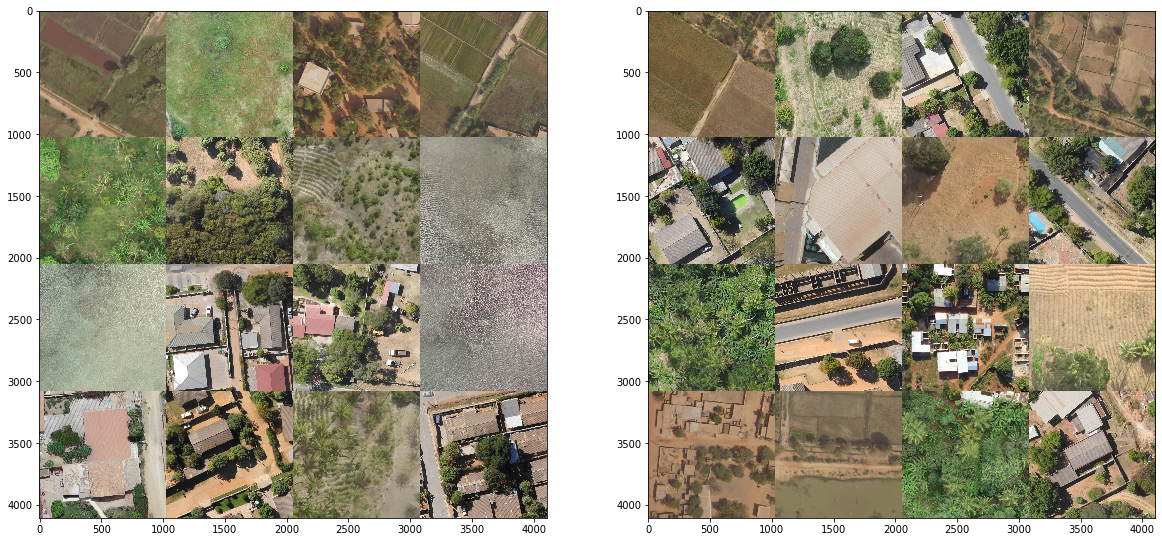

In [10]:
# batch = next(val_dtld_i)
# imgs, masks = next(val_dtld_i)
(imgs, _), (masks, _) = next(test_dtld_i), next(test_dtld_i) 
# preds = model(imgs.cuda()).cpu().detach()
# imgs = preds
imgs_grid = make_grid(imgs, nrow=4).transpose(0,2)#.transpose(0,1)
masks_grid = make_grid(masks, nrow=4).transpose(0,2)#.transpose(0,1)
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(imgs_grid)
axes[1].imshow(masks_grid);

In [8]:
# model = pt.segmentation_models.DeepLabV3(
#     'se_resnet50', output_stride=16, num_classes=1 if BUILDINGS_ONLY else 3
# ).cuda()
or_model = pt.segmentation_models.Unet(
    'se_resnet50', num_classes=1 if BUILDINGS_ONLY else 3
).cuda()
optim = torch.optim.AdamW(or_model.parameters(), lr=3e-4)
model, optim = apex.amp.initialize(or_model, optim, verbosity=0, loss_scale=2048)
# freeze encoder
# for p in model.encoder.parameters():
#     p.requires_grad = False
loss = pt.losses.JaccardLoss(mode="binary" if BUILDINGS_ONLY else "multilabel").cuda()
loss = pt.losses.CrossEntropyLoss(mode="binary" if BUILDINGS_ONLY else "multilabel").cuda()
pt.utils.misc.count_parameters(model)

(35051968, 35051968)

In [9]:
model = apex.amp.initialize(or_model, verbosity=0, opt_level="O0", loss_scale=2048, enabled=False)

In [10]:
example = train_dtst[0][0]
example = example.view(1, *example.shape) #.cuda()
example.shape

torch.Size([1, 3, 384, 384])

In [12]:
pred = model(example.cuda())

In [25]:
model = model.eval().cpu()

In [13]:
with torch.no_grad():
    jit_model = torch.jit.trace(model.cpu().eval().forward, example.detach().cpu())

RuntimeError: Cannot insert a Tensor that requires grad as a constant. Consider making it a parameter or input, or detaching the gradient
Tensor:
(1,1,.,.) = 
   0.3425   0.2468   2.3105  -2.4102  -0.6509   1.4854  -0.1423
  -0.4478  -0.7793   0.9678  -5.2930  -4.1406   3.0020   3.2910
   2.5117   2.0215   5.3047  -4.1289 -16.6094  -5.9844   4.3281
   0.5640   1.9766  16.1094  19.0469  -6.8047 -13.4844  -3.4375
  -4.2773  -9.3906   0.0235  22.5000  16.5781  -2.2559  -3.7617
   0.3137  -7.3086 -13.8203  -2.6680  12.2031   3.6816   2.0176
   3.4336   2.5430  -4.1484  -8.3047   0.9600   0.4790   0.9795

(2,1,.,.) = 
  0.1573 -0.6948 -1.5068  0.1901  0.2489 -0.2050  0.3101
 -0.1938 -0.5039  0.1838  1.4277  1.0957  0.8145  0.7817
 -0.3650 -0.6445  1.0264 -0.3879 -2.1953 -1.3545  1.8564
 -0.5547 -0.9565 -1.9180 -5.8906 -8.1953 -8.7344 -2.9766
 -0.9219 -0.9668 -1.0840 -3.8555 -6.7148 -7.3008 -1.5615
 -0.6572 -0.8521  0.7583  1.2725 -0.1827 -1.1514  1.4160
  0.7305 -0.2205 -0.0299  1.9033  1.6943  0.4575  1.3877

(3,1,.,.) = 
  0.2047  0.5190  0.7314  1.2344  1.5664  0.5962 -1.3467
  0.9902  1.9912  2.2285  2.5332  3.0352  2.4746  0.9443
  0.9780  1.9580  1.8516  1.9580  2.3770  2.8633  1.8477
  1.0010  2.2969  1.8711  1.8359  1.8926  2.8066  2.3105
  1.4609  3.0449  2.9336  2.5820  2.4512  3.2832  3.0566
  1.6748  3.1934  3.2148  2.9668  3.0508  3.8184  3.5020
  1.1035  2.2207  2.3848  2.5645  3.1504  3.3809  2.9062

(4,1,.,.) = 
  2.2617  2.1777  1.1377  1.1045  1.0371  1.6279  2.9551
  2.1250  1.5459  0.7734  0.6411  1.9492  1.4795  1.2979
  1.4619  1.1621  0.3960 -2.2148 -1.2070  0.6304  0.2979
  1.1367  1.9248 -1.4629 -5.7891 -4.7930  0.5283  2.3145
  0.6475  0.9814 -3.7422 -8.8359 -8.9297 -2.9727  1.4072
  0.7954  1.2148 -1.9316 -7.3438 -8.1172 -1.5156  1.3711
  2.1953  1.8877  2.6094 -0.4697 -0.4812  2.9023  3.3301

(5,1,.,.) = 
  1.4697  0.1497  0.3228  0.6265  0.4443 -0.2920 -0.2137
  1.4160 -0.7896 -0.8774 -0.7759 -1.2812 -3.1523 -2.4531
  0.7754 -1.0488 -1.1250 -0.0286 -0.1492 -3.0840 -3.9141
 -0.1885 -1.4609  0.4956  7.0117  7.3555  1.5654 -3.1855
 -0.5815 -2.2227 -0.1948  6.7500  9.8281  3.5605 -2.8887
 -0.4607 -2.4570 -1.4639  2.1699  5.3555  1.5938 -3.2949
 -0.9775 -2.2930 -3.9629 -1.7803 -1.0527 -2.0918 -4.6133

(6,1,.,.) = 
 -1.1152  1.2012  0.9473  0.7466  0.8340 -1.9619 -0.7578
 -1.2119  2.1777  2.5410  3.5684  2.4785 -0.1901 -0.1147
 -0.8184  1.5010  0.9448  1.8486  2.5039  0.6577 -0.2186
  0.4861 -0.1965 -1.7490 -0.8232  1.8662  2.8711  2.6738
  0.0497 -1.2900 -4.0586 -3.0508  0.1196  2.1191  1.7588
 -0.3359 -0.6694 -3.9863 -3.7402 -1.2480  0.3838  0.9775
  0.0452  1.4541 -0.6025 -1.4043 -0.3147  0.4929  0.9868

(7,1,.,.) = 
  -3.4863  -5.6016  -4.5898  -7.9844  -9.4375  -8.5938  -7.7500
  -3.3496  -6.8867  -9.4219 -13.8047 -13.5000 -11.6328  -8.6094
  -2.1230  -6.1055  -9.2344 -12.6094 -13.9297 -11.2266  -6.3320
  -3.7227  -5.0703  -6.8555  -9.0156  -8.0938  -5.1680  -2.4258
   1.6523   3.7891   5.7461   8.1016   8.7422   7.6445   5.6914
   4.3828   8.9531  12.9609  18.9531  19.9062  15.7656  10.5078
   4.7344   8.6875  11.3594  15.8438  16.3125  13.3594   9.8828

(8,1,.,.) = 
  -0.3877  -0.6992  -2.2891  -5.7305  -1.8770   2.1934   5.3711
  -2.0723  -6.0195  -5.9453  -9.0547  -1.6855   6.7383   9.5781
  -2.5957  -8.3516  -9.0938 -10.0859   2.2969  11.5078  12.2812
  -8.5703 -13.4844 -13.3438 -10.0469   6.4609  16.1719  15.2344
 -10.2109 -13.7109 -11.5000  -5.2734  11.6250  18.7656  14.0312
 -10.6250 -11.4141  -8.0156  -0.3518  12.1328  15.9922  10.4609
  -9.4219  -8.5625  -3.6289   1.8838  10.5156  10.8438   6.9414

(9,1,.,.) = 
 Columns 1 to 6  8.1787e-01  7.0264e-01  2.8687e-01 -4.7943e-02  5.8887e-01  4.4971e-01
  1.0518e+00 -1.6182e+00 -3.5566e+00  1.2881e+00  5.0312e+00  1.5674e-01
  1.2578e+00 -4.4609e+00 -8.2266e+00  3.7500e+00  1.2305e+01 -1.2021e+00
  4.2227e+00 -6.2773e+00 -9.2812e+00  7.6367e+00  1.7594e+01 -9.7314e-01
  3.0312e+00 -6.8086e+00 -9.3516e+00  5.2344e+00  1.3570e+01 -8.1006e-01
  2.3965e+00 -3.4746e+00 -5.1328e+00  2.5098e+00  6.9844e+00 -1.6787e+00
  1.1143e+00 -1.4102e+00 -1.9443e+00  9.0186e-01  2.9082e+00 -8.9693e-04

Columns 7 to 7  9.3750e-01
 -2.4199e+00
 -6.8945e+00
 -8.7656e+00
 -8.8281e+00
 -3.6270e+00
  3.3423e-01

(10,1,.,.) = 
  -0.4045   0.1896   0.0871   0.1068  -0.7148   0.2120  -0.6455
   0.1415  -1.4658   2.0762   0.8691  -3.5137   2.1270  -0.8193
   0.9570  -1.7607  -3.5117  11.3516 -10.7578   3.4180   0.0795
   0.9976   2.6172 -17.4844  28.7500 -17.3906   0.5684   2.8242
  -1.0996   6.9844 -20.3750  27.1875 -12.2422  -4.6914   4.9258
  -0.7939   4.7891 -11.4219  12.0312  -1.2363  -6.9102   4.0273
  -0.4207   0.0117  -2.6680   3.4277   1.6836  -3.8711   1.3340

(11,1,.,.) = 
  -0.3887   0.1272   0.3452  -0.2209   2.1484  -0.2257  -0.7222
   0.2954   4.7070   2.4863  -2.6836  -1.1787  -1.9795  -0.2369
   1.8945   1.8945  -7.8516  -9.4062   2.6211   2.7598   1.1045
  -2.1074  -7.4102 -12.0625   9.2344  15.1016   0.4338  -2.3164
   1.0703  -0.9233   8.8125  22.5156  -1.4971 -11.8594  -1.3008
   0.6401   1.3984   4.4883  -4.5859 -18.0938  -4.4727   3.1836
  -0.4685  -1.0518  -0.7070  -4.2461  -1.0752   7.6562   2.9785

(12,1,.,.) = 
   0.9385  -0.6968  -0.5024   2.9082   1.5693  -0.9751   0.0298
   0.3618   3.3555   5.0312  -4.3203  -9.7422  -4.6523   0.6133
   0.0340  -2.6738 -15.5234 -12.6719   7.5898  11.3906   4.8203
  -2.0078  -4.0469  12.2031  31.0469  14.6875  -7.1133  -5.1875
   1.9014   8.6641   5.5898 -17.5625 -25.0938  -5.6055   2.7012
  -0.3604  -3.4766 -10.8594  -3.1602  15.5781  11.8906  -0.9766
  -0.0837  -0.2686   3.5469   5.4062  -4.0234  -7.1406   0.8057

(13,1,.,.) = 
   0.5859   0.9355   2.0352   3.0000   2.4512   1.0312   0.1906
   0.1456  -3.7344  -5.9258  -6.9180  -4.6211  -1.6055   0.2258
  -1.9014  -5.8086  -8.5234 -10.4844  -9.8438  -6.7461  -2.2754
   2.5156   7.6719  12.0703  14.0703  11.2734   6.5352   2.7793
   2.3516   6.7930  12.7578  15.3594  12.2422   5.5781   1.9971
  -3.1621  -6.7500 -10.3359 -10.9688  -8.9844  -5.5273  -2.7578
   2.6484  -0.2598  -2.9492  -3.8848  -3.6562  -0.3052   2.5488

(14,1,.,.) = 
 -1.2695 -3.2871  0.0887  3.8086  0.1570 -2.1758 -0.6938
 -1.7285 -1.6289  3.6855  5.2617 -0.3501 -1.1152  1.2754
 -0.6567  2.8516  7.9297  6.9805 -0.3271 -3.4824  0.2151
  2.6855  6.7891  8.2266  0.6333 -10.4688 -8.3594 -0.1238
  0.2267  1.0996 -1.8604 -11.7656 -13.8906 -1.8906  4.0938
 -1.0908 -0.1974 -2.8828 -7.7188 -2.9414  6.3047  5.4805
 -0.0919  0.6211 -2.0586 -2.4590  3.0078  4.9219 -0.6318

(15,1,.,.) = 
 -0.3762 -0.7964 -0.8994 -0.8018 -0.6206 -0.5400 -0.3625
 -0.5850 -0.8379 -0.8477 -0.7583 -0.7974 -0.6538 -0.5054
 -1.1221 -1.3506 -0.6768 -0.3950 -0.7788 -0.8999 -1.0625
 -1.0098 -0.9502  0.3181  1.4766  0.1284 -0.8809 -1.3760
 -0.7832 -0.6494  0.9927  2.4727  0.8477 -1.0039 -1.2891
 -1.0215 -1.4912 -0.5098  0.4243 -0.4514 -1.0625 -1.2070
 -1.2441 -1.6494 -1.2773 -0.8130 -1.4053 -1.3340 -1.3154

(16,1,.,.) = 
 -1.1348 -1.4980 -2.5293  1.9023  5.3398  1.7490 -4.0234
 -0.5874 -1.3857 -4.6719  0.4175  5.6406  7.3516  1.0479
 -1.6885 -1.6436 -8.0391 -6.6719  0.8921  7.3320  5.6445
  2.0469  2.3672 -6.4102 -12.2500 -7.4492  1.9619  5.8359
  2.8359  7.2578  2.1445 -8.2500 -10.9453 -4.8008  0.7822
 -0.2010  5.7461  6.0586  0.0703 -5.9492 -4.1680 -0.6865
 -3.0801  2.1406  4.9258  4.1914 -2.1211 -4.6367 -1.2168

(17,1,.,.) = 
  2.1855  0.1476 -0.2014 -0.3279 -0.2839  1.6084  2.8066
  0.3354 -1.5820 -2.1484 -3.0410 -2.1875 -0.9922 -0.0279
 -0.8101 -2.2148 -4.0469 -7.0312 -5.9453 -3.7168 -1.7363
 -0.8154 -3.4688 -6.5391 -11.7812 -11.0859 -7.4648 -4.0234
 -0.2329 -3.4219 -7.2773 -12.2812 -12.0547 -7.7422 -5.0391
  2.2930 -0.9741 -4.6367 -8.2578 -9.3047 -6.5625 -3.8320
  3.0840  1.3369 -1.4023 -4.4023 -4.5664 -3.2930 -1.3643

(18,1,.,.) = 
 -0.9712 -0.4473  0.0027  1.2256  0.1414  0.1774  1.5752
  0.9390  2.3398  2.3906  1.7168 -0.3752  0.9268  3.5098
  0.3103  1.9648 -0.0629 -1.5039 -3.4336 -3.1523  0.6836
  0.5742  1.5391 -1.7334 -2.7051 -4.4023 -3.6426 -0.2632
  1.5283  1.3691 -0.4050 -0.8735 -1.9766 -1.3438  1.1191
  0.4553  1.1094  0.6025  0.7261 -0.4258  0.2144  1.4541
  0.4382  0.7539  0.5244  1.5801  0.3315  0.4502  1.0537

(19,1,.,.) = 
   1.4590   1.1270   0.2238  -1.6543  -1.7959  -1.0195   0.7759
  -1.4639  -1.4209  -1.5557  -0.6973   1.9277   1.2715  -0.5430
   0.9946   4.4531  11.3984  19.4688  17.2812   8.7500   2.3535
  -1.5264  -4.0352  -8.1328 -13.1562 -13.8438  -8.4453  -3.1562
  -0.9766  -3.0762 -12.4531 -24.2188 -21.1094 -10.5703  -4.0391
  -0.2223   2.0645   9.7344  18.6094  18.9844  10.1562   2.4766
   0.9658   0.9712   1.5801   1.1250   0.7720   0.5283   1.3770

(20,1,.,.) = 
  -1.2002  -0.9316   2.3125   5.7969   5.3477  -4.3477 -10.3828
  -1.2383  -0.9990   2.9668   9.8672  14.0000   5.1211  -5.3594
  -3.9609  -5.0430  -1.0732   7.7852  18.7344  14.3438   2.0938
  -6.3281 -10.7656 -10.0703  -2.3320  16.1406  19.0000  13.1641
  -5.6523 -12.6953 -17.9062 -21.2812  -2.2695   7.9492   7.9219
   4.8711  -2.2383 -10.1719 -21.0312  -9.3984   0.7651   2.2949
  10.0078   6.6211  -0.6919 -14.4141  -9.7188  -0.9824   1.2256

(21,1,.,.) = 
  0.3608 -1.2480 -0.8926 -0.9751 -1.5303 -2.3281 -0.4622
  1.5098  0.8647  1.1270  2.5254  0.1829 -2.6973 -2.9062
  1.3291  0.7178  0.3079  4.2852  4.3086  0.4404 -1.7598
  0.8022 -1.6973 -3.6504 -0.1349  4.1094  3.2539  1.2031
  2.2852  2.2363 -3.5078 -5.8711 -1.0469  0.4011  0.0693
  0.0083  4.0469  3.0508 -1.2061 -0.6274 -0.0060 -1.4453
 -5.0156 -0.2834  3.0898  1.2881  0.8374  1.5459  0.5830

(22,1,.,.) = 
   1.0830  -1.0537   1.4473   2.0801   0.1638  -1.6943   0.3372
   0.5088  -3.1758   3.5723   7.8867   0.1142  -6.0938   0.3945
  -1.8984  -7.2227   5.9141  13.7656   0.5469 -11.5000   0.4448
  -2.3906 -10.3281  10.3828  20.2031  -0.9556 -15.6484   0.4954
  -2.1758 -10.2422  10.6094  19.2031  -3.1016 -14.0000   0.5293
  -1.2207  -8.3047   5.9648  12.6484  -3.0020  -9.1328   0.5415
   1.2510  -3.9785   4.2930   6.5664  -1.0674  -3.9629   0.8818

(23,1,.,.) = 
  -7.6914  -3.9629   0.6064   3.8691   2.9902   0.8340  -2.0664
  -3.3574   2.0703   7.1484   9.7266   5.3984   1.0254  -1.9707
   1.9756   7.6367  11.9688  11.0078   3.7402  -2.1719  -4.5625
   6.2031  11.2031  10.6250   5.2656  -3.4004  -7.9648  -7.1094
   4.2812   6.9883   3.8340  -3.3262 -10.2812 -11.7656  -8.4219
   2.2559   1.9365  -1.0664  -7.8594 -12.3906  -8.0312  -2.3496
   0.7007  -1.0801  -4.0898  -7.6602  -8.0938  -3.3516   3.8203

(24,1,.,.) = 
  -0.4592  -2.6348   1.3389   1.4092  -1.2852   1.1631   2.9512
  -0.0995  -2.4922  -0.7378  -0.0112  -7.0742  -3.0371   5.3281
   1.5410   0.9463   2.7422  11.3594  -3.0801 -13.0234   1.4199
  -0.8755  -3.6973  -6.4531  13.4062  18.7812  -7.2617  -5.2773
   0.4744   0.3132 -13.3750 -13.0000  14.6016   4.2344  -3.0410
   1.9756   7.1523   2.7207 -13.2969  -0.7959   2.9785  -0.3760
  -2.0742   1.8906   6.2891  -3.0859  -2.5215   1.4297  -1.0664

(25,1,.,.) = 
   3.2324   2.1328  -1.1543  -2.0508  -3.9727  -3.5645  -0.0994
   5.5547   6.2305   1.2549  -3.0703  -7.7539  -8.3906  -3.6953
   7.6562  10.4531   6.0000  -2.6094 -10.3281 -10.8516  -6.6758
  10.0156  14.8438  11.3281  -1.3867 -14.6875 -18.1250 -14.1797
   9.9297  16.4844  15.8672   4.0625 -11.6562 -17.8281 -15.3359
   5.9922  14.5547  15.8359   9.4219  -4.8359 -14.3359 -13.1562
   3.3789   9.2891  12.5000  10.0312   0.5996  -8.0625  -9.6953

(26,1,.,.) = 
  -1.7334  -1.2217  -1.4521  -1.3193  -0.3684  -1.9355  -2.5234
  -1.3066  -0.3171   0.1853  -0.0359   0.1571  -0.8569  -1.3252
  -1.9912  -0.1183   0.5835   0.7407  -0.2803  -1.4160  -1.2842
  -0.1877   2.4434   1.4756   3.1270   3.9863   0.7407   0.1368
  -0.0855   2.1816   1.7822   6.7344  12.1250   5.8398   1.1729
  -0.4685   1.9346   1.8486   4.7930   8.4766   4.2461   1.9365
  -2.1016   0.8052   1.1084   1.5771   2.9141   1.5088   1.1299

(27,1,.,.) = 
  -0.5522  -0.4722   1.8057  -0.3164  -1.5039   1.0039   0.7832
  -1.1963   2.5508   6.7461  -1.0322  -5.5938  -0.3440   0.8633
   2.5938   7.2773   2.7637 -15.4766  -6.6016   4.3750   2.1211
   1.4043  -1.7246 -15.9297 -17.1875  12.4453  11.8125  -0.3108
  -2.1328  -5.9531  -7.9453  12.4297  24.3906   0.0249  -7.3281
   0.4011   0.6016   3.4473  13.0781   0.5674 -11.4062  -3.5898
   0.5503   0.4009   0.8081   0.5024  -7.7227  -3.9570   4.4688

(28,1,.,.) = 
   0.2573   0.3240  -0.2793  -0.3757  -2.0508   0.7085   0.0897
  -1.1406   1.1748   0.2164   5.6328   3.0273  -6.2734  -1.6416
  -1.2432  -1.2344  -6.3086  -7.2734  16.1406   8.6406  -5.7383
   0.7021   1.7324   7.1250 -19.0000 -15.6641  16.7344   5.7578
   0.9170  -4.3828  11.9609  17.3125 -22.5625  -9.9141   3.3828
   0.6567  -2.1348  -9.7031  13.6875   9.1016  -5.8320  -2.4023
  -1.1650   4.2969  -3.5449  -5.3320   4.1836  -0.1342  -0.0145

(29,1,.,.) = 
  -0.3472   0.3020   0.0950  -4.0625  -6.2812  -3.3242  -0.7432
   0.0822  -0.6255   2.6699  12.9219  12.8750   3.7188  -0.0145
  -1.0957  -0.7251  -8.6250 -15.4297  -3.1641   6.1914   2.1270
   0.8018   5.3281  12.6641   1.5322 -18.5000 -13.6797  -1.6523
   0.9746  -7.5078  -8.2734  17.1875  30.2969  10.8203  -1.3496
  -1.8330   5.0781  -0.1741 -22.7812 -22.8906  -6.1797   2.0293
  -0.5269  -2.1445   2.2598  10.4219   8.3047   2.0645  -1.7568

(30,1,.,.) = 
 -1.6338 -5.4844 -7.4766 -8.9766 -8.3438 -6.6094 -4.8047
 -4.1562 -7.1914 -7.5234 -8.7266 -8.9453 -7.8438 -7.6055
 -1.5664 -3.0820 -3.3438 -3.7207 -4.4766 -3.8809 -3.8984
 -0.8643 -0.2581  0.5869  0.6709  0.3276  0.0162 -0.3081
  1.6191  4.8633  5.3047  5.9258  5.0469  5.1289  3.8477
  1.2979  6.1680  7.6719  8.7656  7.6992  7.2891  6.3281
  0.1309  5.8398  8.1094  8.7344  9.0391  8.2109  5.5039

(31,1,.,.) = 
   1.1504   0.2277   1.1094  -2.9883  -3.6309   2.0059  -0.2026
   0.4546   0.7563   6.4961  -5.0703  -9.2422   6.3555   2.1465
  -1.7822   1.1377  12.7109  -7.8672 -17.5469  10.5625   3.2324
  -2.9043   0.5508  15.2266  -6.6016 -25.0000  11.4609   5.9609
  -1.8037  -0.1600  14.4531  -2.1797 -23.8750   8.0703   6.7969
  -0.3430  -1.1475   9.1953  -0.3188 -15.5000   5.1680   4.2344
   0.6978  -0.7085   4.0234  -1.8750  -8.7344   1.3213   1.0928

(32,1,.,.) = 
  0.1873 -0.8403 -1.6133 -1.4238 -0.6172 -0.2180  0.0630
 -0.3066 -2.1270 -2.5195 -2.6875 -2.0684 -1.5967 -1.0400
 -1.4072 -3.1660 -2.8945 -2.8164 -2.5488 -2.1484 -1.2432
 -1.6729 -2.9961 -2.7715 -2.4199 -2.3125 -1.7188 -1.1309
 -0.9873 -2.3965 -2.5332 -2.2734 -1.5547 -0.9902 -0.6855
  0.0364 -1.2432 -1.7139 -1.1309 -0.3218 -0.2551 -0.4839
  0.4219 -0.5044 -1.3311 -0.7769 -0.6450 -0.9185 -0.9180

(33,1,.,.) = 
  -5.0703  -6.0859  -6.4492   4.2891   5.3750  -0.0697  -2.0684
  -6.1250  -5.4023  -0.6641  12.0938  10.3984   1.2139  -2.0781
  -4.6797   0.0997   8.8125  22.2500  13.1719  -1.2217  -3.9258
   5.3789  11.3438  19.4375  23.9375   2.4023 -11.6562  -8.8125
   5.7031   9.6719  11.4688   4.1289 -19.7500 -21.7812 -10.1562
   1.9463   2.4590  -0.3315 -10.5469 -21.8438 -14.0859  -0.8711
  -0.5210  -1.4717  -2.7812  -7.4766 -11.5859  -1.1045   8.4141

(34,1,.,.) = 
 Columns 1 to 6 -3.6713e-02 -3.7622e-01 -6.6406e-01 -3.6499e-01 -3.2886e-01  4.1016e-02
 -1.6882e-01 -5.1074e-01 -3.7598e-01 -3.0640e-01 -3.3203e-01  9.3341e-05
 -2.9346e-01 -3.8135e-01 -6.0400e-01 -1.0742e+00 -7.7930e-01 -3.1274e-01
 -1.0020e+00 -1.5186e+00 -1.8252e+00 -8.8574e-01  3.8300e-02 -9.2334e-01
 -2.0483e-01 -8.9502e-01 -8.3643e-01  2.0020e+00  3.6270e+00  6.8408e-01
 -3.4399e-01 -5.7812e-01 -1.1787e+00  2.1375e-01  1.0459e+00 -6.4648e-01
 -6.7285e-01 -6.2793e-01 -1.1738e+00 -1.7900e+00 -1.6309e+00 -1.5850e+00

Columns 7 to 7 -2.5195e-01
 -3.1433e-03
 -7.6538e-02
 -1.6240e+00
 -1.2285e+00
 -1.2236e+00
 -1.6445e+00

(35,1,.,.) = 
  -1.6309  -0.1790   2.3730   3.0449   1.6113  -3.5898  -8.5234
  -0.6094  -0.5586   3.6133   6.2578   7.2617   2.1289  -5.0508
  -1.6309  -2.2285   2.3281   6.9375  11.9844   9.1641   2.3027
  -2.7559  -5.6367  -3.5215   2.8477  11.4219  13.9062   9.2812
  -3.4238  -9.4688 -10.4297  -7.2539   1.8408   8.8125   7.8125
   0.2844  -5.3086 -10.5859 -12.4531  -5.7227   1.7012   4.2344
   6.4141   1.1826  -5.1992 -10.2812  -8.5156  -4.0703   0.3320

(36,1,.,.) = 
  3.3672  0.8555  1.0449 -0.4319  1.8740  2.7344  4.4414
  2.6504 -0.9111 -0.6968 -4.8320 -2.6875 -0.0182  1.4814
  2.3848 -2.2344 -3.2949 -7.6289 -6.3594 -1.4688  1.0918
 -1.0352 -7.0156 -7.3398 -10.5938 -9.6016 -6.6367 -2.7656
  0.4028 -4.9141 -6.6641 -8.3906 -7.0312 -5.5469 -2.4062
  2.4355 -2.6211 -3.7031 -7.2461 -4.8789 -0.9209  2.4375
  4.3711 -0.9390 -0.9175 -4.4883 -2.7676  1.8203  4.3125

(37,1,.,.) = 
  -0.8267   0.2556  -0.4626   0.4490   0.4180  -0.2898  -0.4111
  -0.3860   0.3242   3.4297   6.3398   7.4961   5.7383   1.5898
  -0.4209  -0.3481  -2.2266  -4.5391  -7.0117  -5.9258  -3.6016
  -1.6562  -4.7734 -12.5703 -20.6719 -21.3281 -13.4688  -4.2305
   2.1660   5.9688  12.5156  18.7188  19.4844  15.0625   8.0312
  -1.4531  -0.7070   1.6777   6.4062   8.2266   3.8047  -1.7510
   1.4062  -0.0897  -2.5820  -7.0234  -6.9531  -4.5469   0.5024

(38,1,.,.) = 
 -0.0450 -1.8604 -1.6230 -1.6855 -2.3184 -1.6787 -3.0781
  1.0195 -0.0903  1.3008  2.6152  4.9492  5.5430  2.2422
 -0.0172 -1.4199  0.4004  3.4980  6.9922  7.2070  3.6309
  0.2427 -0.3831  0.3706  2.4766  4.7695  6.5352  4.2891
 -2.0840 -2.1426 -0.7734 -1.2695  0.1837  1.2402 -0.7539
  0.1484 -0.4121  1.1133 -0.8521 -0.8521  0.0681 -2.9141
  1.0625  0.3306 -0.0212 -0.0013 -1.3779 -2.1641 -2.3105

(39,1,.,.) = 
  0.2169  0.9561  1.8965  3.0566  1.4346  0.3020  0.4641
  1.0781  0.2778 -4.1602 -2.3770 -0.4521 -0.3589 -0.1923
  1.8662 -5.4141 -11.5391 -9.8516 -2.3008  0.7734  0.1650
  2.0879 -1.7441 -5.3594 -1.5000  4.4570  1.3887  0.9814
  0.9414  0.8916  2.4746  3.3848  2.0996 -0.8672  0.1554
 -0.4893 -0.4209  0.1392  1.1455 -0.5928 -0.7334 -0.2114
 -0.7544  0.1804 -0.3435 -0.1335  0.4058 -0.3984  0.3254

(40,1,.,.) = 
  0.7202  0.1181  0.2180  0.6318 -0.1478 -0.1909 -0.1304
 -0.8232  0.0736  0.4102  1.0137 -0.7495 -1.6172 -1.1709
 -1.7051  1.7549  1.5156  1.1914  0.3286 -0.4324 -0.7310
 -0.8701  4.1680  3.7930  3.2383  2.2246  1.6045 -0.7842
 -0.4729  3.8203  3.8340  4.4219  3.2969  2.3027 -0.5293
 -2.1621  4.0078  4.1211  5.6875  3.5508  2.6758 -0.2693
 -4.2617 -0.2068  0.2081  4.3477  2.7676 -0.1000 -2.3398

(41,1,.,.) = 
 -1.0254  1.9355  0.9106  0.0577 -2.2852 -3.3398  0.2029
  3.4434  6.7656  3.8672  1.1592 -3.1055 -6.2578 -5.0039
  6.0508  8.2656  5.0312  1.0781 -4.0820 -7.4688 -5.8516
  5.8008  7.4609  4.0977  0.8989 -5.3359 -8.7109 -7.7695
  6.7773  7.9453  4.5000  1.4590 -4.1289 -8.4922 -7.3125
  5.8008  7.3203  4.8867  1.5791 -3.6055 -8.0547 -6.3789
  2.7480  5.4336  3.8379  1.0078 -4.1328 -8.0859 -4.0547

(42,1,.,.) = 
 -2.5996  3.4395  6.5664  7.5820  9.2812  8.7812  6.1641
  1.6064  6.1445  8.6484  8.6875  9.3047  8.6172  6.5469
  2.2637  3.9316  4.2695  4.9336  4.7266  4.2500  3.4023
  1.1709  1.0176 -0.9780 -0.9321 -1.4014 -1.4277 -1.9658
 -1.3945 -2.9102 -3.9141 -4.3906 -5.4375 -5.3320 -5.6016
 -3.4590 -6.1992 -7.1016 -8.5156 -9.0312 -9.5000 -9.6094
 -0.3391 -3.5840 -4.8164 -6.4453 -7.2461 -5.8281 -4.0781

(43,1,.,.) = 
  1.8838  0.0935  0.5596 -0.8486 -0.1691  0.4016 -0.2610
  0.4875 -1.6348 -3.0371 -6.6523 -5.1328 -2.2422 -1.7920
  1.0615 -0.9766 -1.5547 -5.1641 -3.6582 -1.2314 -0.0392
 -0.2698 -3.5000 -3.4629 -4.0625 -3.4375 -2.9590 -0.4785
  1.1367 -2.4316 -3.4004 -3.8750 -2.4980 -1.6221  0.3240
  1.5439 -1.6045 -3.3301 -5.8359 -3.0859 -0.8989  1.0996
  1.3223 -1.4004 -2.9180 -7.3008 -3.1035 -0.1388  0.6851

(44,1,.,.) = 
   6.1406  -2.4023  -9.9062  -8.2109  -0.5146   0.7568  -0.7085
  -1.9717 -13.2969 -15.4062  -6.3281   4.0469   3.9277   1.3789
  -7.3125 -14.6953  -9.1328   4.9883  12.3828   8.3594   3.8301
  -5.7109  -5.9336   3.1055  13.4609  16.5625  10.5469   3.4727
   1.3232   1.9414   9.8203  16.2812  14.3672   4.9258  -3.2852
   1.7715   3.7168   9.1016  11.8047   4.8672  -5.6250 -11.4297
  -0.3074   0.4421   4.8672   3.2148  -5.3984 -13.3203 -12.9688

(45,1,.,.) = 
 -0.3601 -3.9258 -2.3047 -0.4727  2.3613  2.7754  1.6279
 -4.9180 -7.5859 -4.1758 -0.3523  3.7480  4.2031  5.6211
 -5.7422 -6.8438 -3.6660  0.3586  4.4414  6.9102  8.4766
 -5.9102 -7.9844 -4.4414 -0.8804  4.5664  6.5430  7.9570
 -7.4531 -7.4062 -4.6406  0.0366  4.7773  7.2266  8.3438
 -5.7344 -6.6016 -3.2695  0.7422  4.2227  5.7891  6.9688
 -4.6367 -5.5156 -2.0625  0.4626  3.6602  5.2305  4.3398

(46,1,.,.) = 
   0.0059   0.9502  -1.0215  -0.0752  -0.3755   1.0693  -0.6211
  -0.3782   0.9702   0.3411  -1.1211  -0.3228   1.7949  -0.8101
  -0.3403  -0.5293   1.8555  -6.8906   8.7578  -6.1484   1.3330
  -1.5869   3.5801   0.5747 -15.5234  27.3125 -21.2500   7.4844
  -2.2324   7.3008  -3.0039 -15.5156  30.3594 -22.8281   7.6484
  -1.8223   4.2969  -5.3789  -5.0352  14.4062 -11.1016   1.6689
   0.7515   1.5010  -4.1914   2.2188   2.7383  -1.2783  -0.3533

(47,1,.,.) = 
 -0.9414 -1.8936  0.0619 -0.6558 -4.5547 -7.7266 -6.0547
  0.7017  0.9570  4.0547  4.1367  1.4639 -4.7305 -8.5234
  1.4121  2.0820  6.3320  7.9727  5.8086  2.2676 -4.3672
  0.4390  1.4482  6.2930  9.5859  8.0547  6.8398  1.3711
 -2.2812 -2.5879  2.4902  7.0156  7.0977  6.5352  3.0664
 -5.5430 -11.8047 -7.8633 -0.8657  2.9512  3.0820  1.1758
  3.2422 -8.0781 -10.8281 -6.7891 -2.1367 -0.3877 -0.9272

(48,1,.,.) = 
   5.7852   9.2188  10.8828  13.3125  14.4375  13.2891  11.2734
   3.5645   8.2969  12.8906  15.8516  15.5000  13.4844   9.6562
   1.5264   4.7070   7.8711   9.8516   9.8906   7.7383   4.6992
   0.8208   1.1748   0.3696  -1.7188  -1.9473  -0.2766  -0.1382
  -2.0977  -5.4180  -7.1406 -11.1953 -11.7500 -10.2188  -6.6641
  -4.3203  -8.1406 -11.5000 -15.6641 -15.5703 -12.8750  -9.2266
  -5.0781  -8.3281 -10.0234 -12.7891 -11.7656 -11.5781  -8.7734

(49,1,.,.) = 
  -3.6035  -2.8926  -0.8296  -4.7578  -4.2812  -5.2344  -5.9805
  -2.6758  -1.5664  -1.0273  -5.5352  -4.7812  -4.1445  -4.9961
  -1.5020  -0.6250   0.5278  -1.5859   0.3210  -0.3752  -1.1582
  -5.0000  -4.2109  -1.8350   1.7295   9.8203   8.8203   1.0918
  -5.0117  -4.2812   0.8232  10.3672  23.9531  21.4219   6.0078
  -5.4805  -3.5371   0.1260   8.6250  20.9062  17.2500   2.4238
  -6.0195  -4.5156  -1.6064  -0.9658   4.4336   2.0762  -5.5078

(50,1,.,.) = 
  -1.2275  -0.6792  -1.8545   1.7246   0.3018  -1.9873  -3.1738
  -0.8433   0.1639  -1.0225   4.5977   1.5020  -1.0713  -1.7744
  -1.8613  -1.5908  -0.0189   7.6602   6.8008   1.3594  -1.8838
   1.3125   2.8613   7.7070  21.4062  22.4531  14.0000   7.5352
  -0.4739   0.2517   5.4180  21.3906  22.1875  14.5078   7.3438
  -2.4551  -2.0820   1.8359  13.6016  15.4219   9.8203   4.0312
  -3.1895  -2.9688  -0.9541   7.3555   7.5547   3.6289   0.0692

(51,1,.,.) = 
  0.3081  1.1240  2.1367  3.4980  3.8184  5.4375  3.9805
  1.7969  2.6582  3.2539  2.8105  2.7441  3.6094  4.4453
  2.5312  3.2305  3.0879 -0.1624 -0.4458  0.3611  1.4883
  2.5137  2.2676 -0.3311 -6.8672 -8.6484 -7.9531 -4.8359
  2.9551  2.1582 -2.1504 -9.8906 -12.3125 -10.5625 -7.8398
  4.0742  2.5762 -1.9854 -8.8594 -12.2734 -10.4141 -6.5586
  4.1953  4.2852  1.1982 -4.8125 -6.2109 -5.2305 -1.5771

(52,1,.,.) = 
  -1.4385  -1.7090  -2.5332  -2.6758   0.8638   7.8672   3.5938
  -0.0856  -1.2920  -4.5703  -8.2266  -5.8945   7.8125   9.2422
   2.3594   1.3936  -2.8730 -12.8516 -19.0625  -0.0942  12.6250
   3.5566   5.5977   4.4648  -6.2852 -28.7969 -23.3750  -6.4961
   5.4023  12.3047  15.7266  14.7891  -5.2930 -14.9219 -10.8203
  -4.0586   2.6562  11.9766  18.4219   8.6406   0.2861  -2.5664
  -9.1797  -8.2734  -0.3945  11.6797   7.5312   2.5449   0.1915

(53,1,.,.) = 
 -1.2373 -0.4607  0.2974 -0.6899  0.2001 -1.1992 -1.2793
  0.2844 -0.1976  1.6689  1.6836  1.3242  2.2051  1.4062
 -0.1437  0.7476  0.6230  1.9648  1.7500  2.5098  2.8398
 -0.8652  1.7715  2.3496  3.0469  3.5957  4.1914  3.9922
 -0.5288  1.3057  2.0508  4.0352  5.1055  5.4648  4.1719
  0.4788  0.9805  3.8789  6.3320  7.5547  7.1953  5.4883
 -0.0895  1.6719  2.7715  5.2461  6.6094  7.0078  5.1602

(54,1,.,.) = 
  -0.2705  -0.4841   0.3899   1.3379   2.1016  -3.1875  -0.6440
  -1.2402   3.8828  -4.4062   0.6978   3.3691  -5.3086   0.8618
   2.5684  -1.5264  -7.8516  16.7969  -4.1719  -6.5859   3.3633
   0.8770  -8.6797   9.7422  15.0078 -28.3750   3.6895   4.7305
  -1.7061  -1.5830  15.6641 -14.6641 -16.1250  21.2812  -2.7500
  -1.2852   3.0723   1.7773 -15.7188  10.1953   8.0156  -6.6797
   0.4036   1.0303  -2.9570  -3.9180   6.7891  -1.9707   0.3171

(55,1,.,.) = 
  5.3438  0.4490 -2.3750 -1.4375 -0.8472 -1.5537 -0.3059
  1.5000 -2.3105 -4.0938 -0.8696  0.5757 -0.0392  1.0596
 -2.2090 -3.9180 -2.1816  4.5586  2.2559  0.4624  1.6709
  0.2844  0.0122  4.0469  6.3242  0.0311 -0.5229  0.6313
  0.2610 -0.5601  1.4502 -0.6426 -5.0781 -3.7852 -0.5977
 -1.5654 -1.4492 -1.8486 -2.0566 -4.4609  0.1462  3.2285
  0.3071  0.7031  1.3105  0.7231  0.6543  4.0742  2.4961

(56,1,.,.) = 
 -0.6133 -0.3245 -0.1910  2.2012  2.9648  1.9844  0.4165
  1.8965  1.5420  2.2129  4.6523  5.6250  3.7266  1.4453
 -1.2021 -2.2461 -2.6309 -1.7188 -3.0430 -3.8184 -3.7559
 -0.3223 -1.1143 -4.0781 -7.1367 -10.0547 -7.8086 -5.6562
 -0.2405 -1.0029 -1.7930 -4.5859 -5.3594 -5.0352 -4.9297
 -0.2595 -0.6084  0.8779  2.6660  2.4805  2.2227 -0.0405
 -0.0833 -0.1412  2.2168  4.9023  6.3047  5.3672  3.4766

(57,1,.,.) = 
   0.3125  -0.4973  -0.3413   0.4368   0.7812   0.2120   0.4775
   0.7490  -3.9238  -3.5723   8.0938   2.3262  -1.1943  -0.0426
  -2.8926  -4.7266  13.4531   7.7812 -12.0781  -2.1328   1.2861
  -2.4102   8.5938  13.2344 -20.8281 -10.4688  11.1094   1.2197
   1.7324   7.0898 -12.0625 -16.2344  19.4375   6.9961  -4.7930
   0.3269  -0.1874  -8.6797   7.3477   9.5859  -9.7188  -0.3591
   1.2686  -1.0332  -0.9521   7.1406  -2.2871  -3.1699   1.5088

(58,1,.,.) = 
  -0.0897  -0.1589  -0.8745  -0.7832   0.0502   1.2148   1.2119
   0.3225  -2.0215  -5.8242  -7.0039  -4.5625  -2.4316  -0.0452
   0.5806   3.8770   7.4453   6.6328   2.1855  -1.8770  -1.0879
   2.6484   7.7695  15.9609  20.6094  18.2031  11.0312   4.5781
  -4.7461 -10.5625 -16.8750 -19.1406 -13.3438  -6.7383  -3.3945
   2.1523  -2.0156  -5.7188  -9.4922  -9.0469  -4.2109  -0.2883
  -1.0156   2.6719   6.5156   7.6250   5.8945   2.2051  -0.3083

(59,1,.,.) = 
 -0.8765 -0.8931 -1.3623 -1.3643 -0.6763  0.1874  0.3604
 -1.0176  0.0762  0.2179  0.6343  1.5264  2.2598  1.5557
 -1.9492 -0.3281  0.7690  3.1152  3.8242  3.0156  1.7793
 -0.3413  2.3477  3.6211  4.9336  4.5742  3.3730  2.4609
  0.0868  3.1973  3.7949  3.9023  3.3691  1.9014  1.7002
  0.1722  1.8193  2.6875  2.5312  1.3096  0.2378  0.3843
 -0.0429  0.7598  2.0332  2.0332  0.9351 -0.3020 -0.7324

(60,1,.,.) = 
  -0.4714  -0.3000  -0.3333  -0.0127   0.2036   0.2424  -0.1116
  -0.1186   3.1387  -2.8926  -5.8164   3.8301   3.7168  -0.6812
  -0.3743   6.3867  -4.6758 -14.0859   6.6289   8.3672  -4.0625
  -0.1195   9.0312  -4.2578 -20.4062   8.8906  13.1719  -5.0312
   0.1637   8.0469  -5.3906 -19.7656   8.4219  12.3750  -5.8242
   0.5845   5.6953  -4.5469 -11.2422   5.6328   8.7500  -3.7402
  -0.1177   2.0820  -4.1992  -4.7930   3.4082   3.1172  -1.0029

(61,1,.,.) = 
   0.2610  -0.9102  -1.6230   2.7676   1.2754   0.3884  -0.7163
   0.7988   0.7544  -1.9717   4.0312  -4.4570  -3.4609   3.0625
  -0.0301   1.1299  -6.7852   6.6953  10.9375 -11.7266  -1.8516
  -0.6626   5.8828  -7.3438 -18.2031  22.4375  10.2969  -6.0352
  -1.6406   4.1250  14.3516 -22.3750 -14.8594  14.3672   2.1738
   0.2059  -7.2422  11.6875  11.1094 -16.1250  -1.6865   3.0723
   0.2317  -1.4688  -4.6602   8.6797   1.2275  -3.5801   0.6704

(62,1,.,.) = 
  0.6821 -0.2334  0.3428  0.6943  0.7446  0.1016  0.4187
 -0.2695  0.3567  1.2480  2.7012  1.3262  1.0254  0.3779
  0.1948  0.8062  2.3184  4.5703  4.7344  2.7266  1.0361
  1.2998  1.8037  3.0449  6.6445  7.2422  5.0430  3.2441
 -0.5332  0.3679  1.0527  5.7344  6.2578  4.7227  3.1875
  0.4949 -0.0246  1.4932  3.6191  3.4648  4.1875  3.0059
 -0.2357 -1.0234  0.9434  2.4824  2.1914  3.0371  1.9668

(63,1,.,.) = 
  -3.0391   1.2588   3.7324   2.4668  -1.6621  -1.9072  -1.9502
   1.6592   6.8438   9.0312   1.5615  -4.4570  -3.0625  -0.9336
   5.4297   9.3203   2.3047 -12.7500 -13.9688  -6.3555  -1.0068
   4.2930  -0.6514 -14.3906 -23.1875 -12.7656   0.5996   7.0312
  -3.7168  -9.6016 -14.6797  -9.3984   4.5938  13.1250  10.1484
  -3.2949  -3.3613  -2.0801   4.6719  12.1953  13.3438   4.0859
  -1.2480   0.2328   1.6748   6.1367   9.8672   4.6641  -6.9844

(64,1,.,.) = 
  -1.5176  -0.4250  -0.0927   1.0303   0.9424   1.0479  -0.7949
  -0.1854   0.4790   0.9478   1.6992   0.7778   1.5400   0.6665
   0.0983   0.7031   0.9170   3.6973   1.8867   0.7461   0.8750
   0.6558   1.7031   3.5879  11.3906   8.3203   3.1055   2.4082
   0.6294   1.5576   2.6445   9.4844   6.9180   2.0703   1.8525
  -0.7407   0.7505  -0.0731   2.5156   1.2988   0.6172   1.0674
  -0.5884   0.3989   0.5703   2.1387   1.0137   1.0918   0.3042

(1,2,.,.) = 
  -0.2725   1.0205   2.2559  -3.5332  -2.1523   2.7695   1.2207
  -0.5874  -0.7603   0.5850  -8.6016  -8.8125   1.1416   4.0664
   2.4512   3.6367   7.6172  -5.2891 -20.7344 -10.4453   2.1895
   0.9028   3.7559  19.8125  22.6250  -7.5273 -18.7188  -7.8242
  -5.0781  -9.6328   3.5020  27.9062  20.6562  -2.4434  -5.5273
  -1.8389  -9.1016 -14.6562  -0.0841  14.2188   5.5703   0.9282
   2.7344   1.2051  -5.5781  -8.4688   2.2715   0.6465  -0.1836

(2,2,.,.) = 
  1.5244  1.1777 -0.6348  0.3237  0.5234  0.0854 -0.2039
  0.8745  0.8140  1.3301  1.3008  0.8184  0.0828  0.3135
  0.7202  1.6250  1.5322 -0.4324 -2.9531 -2.1719  0.5425
  0.9551  1.5586 -1.3467 -5.9297 -8.7266 -9.4922 -3.5605
  0.5728  1.2900 -0.0339 -3.7188 -7.5664 -8.0000 -2.0898
  0.3147  0.4014  1.2988  0.8804 -1.1719 -1.5244  0.5874
  1.6299 -0.1226  0.2739  1.0840  0.4358 -0.4978  0.3533

(3,2,.,.) = 
 -0.8804 -1.7900 -1.7070 -1.1934 -1.0293 -2.0859 -3.4531
 -1.4580 -1.5811 -1.3418 -0.7676 -0.0326 -0.7549 -2.2852
 -1.8271 -1.4609 -1.0498 -0.2428  0.6831  0.9072 -0.5146
 -2.0176 -0.9746 -0.1752  0.7788  1.4619  2.0000  0.5117
 -1.4854  0.0745  1.2754  1.9814  2.6699  3.0781  1.3799
 -1.4902 -0.0948  1.1992  2.1816  2.8984  3.1152  1.5244
 -1.7852 -1.2646 -0.3625  0.3718  1.0791  1.3418  0.1647

(4,2,.,.) = 
 -0.4199 -0.6338 -2.0137 -1.7959 -1.7041 -1.7881 -0.8760
 -0.9487 -2.7402 -2.8984 -2.4941 -2.0879 -2.5391 -2.9629
 -1.5420 -2.2656 -2.0371 -2.8926 -3.0137 -2.0742 -3.3809
 -0.8804 -0.2390 -2.0801 -4.2578 -3.4180 -0.5962 -0.7007
 -1.3262 -0.3923 -4.0312 -7.0195 -7.2461 -2.9805 -1.6611
 -1.3662 -1.3057 -3.6992 -6.9531 -7.4219 -2.4824 -1.8750
 -1.0469 -1.8516 -0.5596 -2.2539 -1.8740 -0.1970 -0.8315

(5,2,.,.) = 
  -1.9443  -0.3147   0.1630  -0.1268   0.4082  -1.5176  -2.2832
  -0.4802   0.8101   1.4717   2.1504   2.6992   0.5718  -0.0748
  -0.2688   1.6709   3.2402   5.5078   5.6562   3.3320   1.7002
  -0.3252   2.3516   6.3672  11.8828  12.1641   8.8047   5.7695
  -0.9653   2.1523   6.4062  12.0547  14.9844  10.8984   6.1602
  -1.8174   0.6714   5.2734   9.6641  11.1562   8.1641   6.2891
  -2.4199  -0.1788   2.5039   5.9922   7.0703   6.0195   4.4102

(6,2,.,.) = 
  0.9189  1.6152  1.0361  0.6650  1.4189  1.2754  3.3516
 -0.2795  0.6973  0.3845  1.0146  1.5088  1.4600  2.6074
 -0.2330 -0.5205 -2.2129 -1.4414  0.4109  1.6562  2.3457
  0.2954 -2.7617 -5.7227 -4.9297 -1.2988  2.4473  3.7773
 -0.0844 -3.2402 -7.1289 -6.6562 -3.1562  1.4727  2.7695
  0.1288 -1.9541 -5.9258 -6.5547 -3.2754  0.9644  2.5664
  0.5591  0.4446 -1.6787 -3.0234 -1.2969  1.5420  2.7461

(7,2,.,.) = 
  2.5117  1.2607  1.4170  1.3057  0.5459  1.5186  2.7344
  1.6523  0.9404  0.8169  1.3438  1.7959  2.0371  1.9512
  1.4219  1.2129  0.9263  1.2197  0.2837  0.2307  0.6118
  0.4258  0.7344  0.4243  0.8311  0.0778  0.3799  1.1523
 -0.5391 -0.6738 -0.6602 -0.5791 -0.9868 -0.6479 -0.5068
 -0.9238 -1.8379 -1.9092 -1.0156 -1.2246 -1.4775 -2.2773
 -1.3779 -2.5137 -1.6650 -1.7324 -1.5820 -1.3662 -1.7285

(8,2,.,.) = 
  1.5342  0.1537  1.0430  0.0782  0.0396 -0.8579 -1.6748
  0.4104  0.5361  1.3789  1.4238 -0.1447 -0.7349 -0.8521
  1.1543  0.3293  1.5537  0.9185  0.5884 -1.0703 -2.0938
  0.7671  1.0957  1.2744  1.1113 -0.7134 -1.9189 -2.5371
  1.2109  1.1240  1.4502  0.1398 -0.0658 -1.9307 -2.3848
  1.7793  1.7061  1.0674  0.3442 -1.4766 -1.6416 -1.2061
  2.3105  1.8818  0.3625  0.3516 -1.2852 -2.2305 -0.7432

(9,2,.,.) = 
  -0.6992  -0.4758  -0.9697   0.8374   3.1367   1.3975  -1.0088
  -1.0020  -4.6211  -5.6914   3.3418   9.1172   2.0586  -5.4258
   0.0933  -8.7422 -10.4297   7.7578  18.2656   1.2656 -10.2344
   1.6592 -11.1953 -12.1797  12.6406  24.5625   1.9297 -12.8203
   0.4443 -12.0234 -11.0703  10.2656  21.0938   1.8867 -12.2656
  -0.2896  -7.7461  -7.2031   6.1953  12.5469   1.3994  -6.2109
  -0.4001  -3.1914  -2.4355   2.7793   6.4258   1.9746  -1.0439

(10,2,.,.) = 
   0.1371  -1.1885   1.0713   0.1638  -0.7988   0.5967   0.1450
   1.0225  -3.6035   2.1367   2.5977  -3.9453   1.7275   0.1293
   1.7822  -3.3789  -3.8711  15.1875 -12.0391   1.7666   1.1904
   1.4658  -0.5195 -18.9844  34.0000 -18.9688  -3.3438   4.1641
  -0.2324   3.9121 -22.1562  33.0625 -12.5078  -8.8359   6.4609
   0.2727   3.2012 -13.4531  15.5781  -1.6660  -8.7500   4.7852
   0.2683  -0.2327  -3.1426   3.8418   1.9092  -4.2695   1.4834

(11,2,.,.) = 
  -0.1126  -0.2603  -0.3867  -1.0654   1.6924   1.3955  -0.2031
   0.6802   2.6074  -1.4512  -5.2188  -0.9941   0.0055   1.1055
   0.2959  -1.3057 -13.2734  -8.5078   6.6953   6.7461   3.1113
  -3.7285  -9.6094 -11.8281  18.5000  23.3125   2.0332  -3.9238
   1.4053   1.2295  15.0625  32.2500   0.9541 -16.0625  -6.1094
   1.9746   2.7207   8.1562  -3.9121 -24.0000 -11.7109   0.0228
   0.4172  -0.2397  -0.9722  -7.6836  -5.8320   5.7148   4.8320

(12,2,.,.) = 
   0.6465  -1.0420   0.0668   3.5781   2.8398   1.1211  -0.6753
  -1.0527   2.6777   4.2812  -4.5039 -10.5156  -4.8945  -0.0248
   0.4434  -2.7422 -14.8750 -11.4688   8.5781  11.9219   3.5137
  -0.4802  -1.9375  14.2734  31.8750  13.4844  -9.9141  -7.6133
   1.6631   6.8906   3.4102 -22.0312 -30.5625  -6.2617   3.0293
  -1.0947  -4.7812 -12.9844  -5.1094  16.6875  13.7812   0.8770
  -0.2053   0.3599   5.3906   7.9180  -1.4551  -6.1602   0.7231

(13,2,.,.) = 
  -0.3452  -1.6250  -0.0448   0.3843   0.3606   0.3938  -0.1478
  -0.8018  -6.2109  -9.5781 -10.3359  -8.9219  -3.2324  -0.3599
  -2.3945  -5.6406  -8.7734 -10.7812 -10.7188  -7.4844  -3.2949
   5.2031  11.2109  17.9219  21.0625  17.3438  10.3750   5.6523
   3.4219   9.6719  17.7031  21.4062  16.0781   8.6719   3.9492
  -3.5000  -7.3555 -10.8984 -11.1172  -9.6484  -6.2344  -3.4961
   0.9526  -4.0195  -7.1523  -8.3984  -7.7734  -3.5898  -0.4158

(14,2,.,.) = 
 Columns 1 to 6 -1.8994e+00 -1.9844e+00  2.3613e+00  6.0352e+00  1.0234e+00 -2.1133e+00
 -1.6230e+00  1.4463e+00  8.0234e+00  9.3906e+00  9.3018e-02 -3.3184e+00
  1.6465e+00  7.6992e+00  1.3328e+01  8.6719e+00 -3.9355e+00 -7.7539e+00
  6.0234e+00  1.0273e+01  9.4688e+00 -3.6953e+00 -1.8125e+01 -1.3062e+01
  1.2578e+00  2.1328e+00 -4.9453e+00 -1.8797e+01 -2.1922e+01 -5.4805e+00
 -1.3086e+00 -5.3125e-01 -6.5742e+00 -1.3609e+01 -6.1094e+00  8.3984e+00
 -4.4189e-01 -7.4402e-02 -3.5508e+00 -4.3906e+00  3.4004e+00  9.3203e+00

Columns 7 to 7 -2.9346e-01
  5.7812e-01
 -1.9551e+00
  4.3726e-04
  7.2305e+00
  1.0336e+01
  5.2891e+00

(15,2,.,.) = 
 -0.2512 -0.6836 -0.8013 -0.8921 -0.6138 -0.3794 -0.0614
 -0.1711 -0.4534 -0.4646 -0.3359 -0.3491 -0.1698  0.0485
 -0.4653 -0.5039  0.1305  0.4897 -0.0143 -0.1007 -0.3630
 -0.0915  0.1588  1.5537  2.5938  1.3018  0.2185 -0.3152
  0.1586  0.7017  2.2422  3.7031  2.1250  0.4006 -0.0266
 -0.1381 -0.1697  0.8691  1.8154  0.9175  0.2290  0.0476
 -0.7822 -0.7573 -0.3215  0.2676 -0.2932 -0.3523 -0.5068

(16,2,.,.) = 
  -0.1829  -1.4502  -3.7441   1.0137   5.8477   3.8242  -1.0859
   0.2412  -2.6836  -6.9375  -2.3516   6.8438   9.0312   4.5078
  -0.5190  -2.5820 -11.9375 -11.5000  -1.0703   9.9688   9.0859
   3.6582   2.3945  -9.8438 -18.2344 -12.5156   0.4358   6.8984
   6.8594  10.9141   2.1738 -11.1406 -15.7188  -7.3789   0.6631
   2.2891   9.6250   8.8359   0.1083  -7.5664  -6.3086  -1.3584
  -2.1777   4.2266   7.9375   6.2344  -1.7510  -3.4883  -0.2467

(17,2,.,.) = 
  -1.8145  -0.5596   0.3933   0.9873   0.2634  -1.1260  -2.8242
  -0.5044   1.8945   3.9023   6.5742   4.8750   2.5156  -0.0586
   0.3223   3.6992   6.7695   7.7227   7.3125   5.7266   3.2285
   2.0957   6.8828   9.9766  12.2578  11.8281  10.2891   6.8164
   0.6748   5.2422   9.4062  12.1094  11.9688  10.9844   7.9219
  -1.2158   3.1230   6.8516  10.9766  10.5234   9.8750   7.2500
  -3.3984   0.4666   3.5293   7.1602   8.1406   6.6406   4.7539

(18,2,.,.) = 
  2.2676  1.5537  1.4014  1.6396  0.0233  0.6387  2.7871
  2.5000  2.2129  1.4131  0.1509 -1.8145 -0.6948  2.3945
  1.4072  1.9580 -1.2070 -3.4102 -5.8320 -5.0234 -0.8730
  1.5488  1.1943 -2.9707 -5.1719 -6.8125 -5.9883 -2.3008
  2.5293  1.4951 -1.6533 -2.9570 -4.0625 -2.8125  0.6621
  2.5156  2.5410  1.1523  0.6021 -0.5869  0.7910  3.0254
  2.7441  2.5859  2.3340  2.5391  1.4453  2.3145  3.5566

(19,2,.,.) = 
   0.1812   1.0713   0.3049  -1.5605  -1.9961  -0.6167   0.6802
  -1.5498  -1.2852  -0.7754   0.0668   2.5781   2.0449   0.6421
   2.1055   5.8945  13.6875  22.0312  19.3750  10.7266   3.1113
  -1.4570  -5.0078 -10.2500 -16.5469 -17.0156 -11.1094  -5.4961
  -1.5391  -4.2734 -13.7969 -26.0312 -22.9531 -12.0391  -5.1289
   0.0206   3.5918  11.1719  20.6562  21.6406  12.5234   3.8145
   1.1279   1.1406   1.2090   1.0361   0.4585   0.3616   1.0820

(20,2,.,.) = 
  0.5596 -0.1199 -0.8496 -0.0963  1.4570 -0.8647 -0.6504
  1.0938  0.4065 -0.5249  0.4783  1.3135 -0.4475 -1.2568
  0.8667  0.6216  0.1820  0.5825  2.2578  1.0928 -0.7061
 -0.1458 -1.5283 -0.9116  0.2637  4.4062  2.7539  2.6055
 -1.0537 -1.1328 -2.6445 -4.8828  0.1150  0.2991  0.0603
  1.2959  0.7339  0.5986 -2.0039 -0.0846  0.4006 -1.4473
  0.6094  0.1294  1.1621 -2.1895  0.5127  1.6973  0.4509

(21,2,.,.) = 
   0.5371  -0.1281   2.2637   3.6641   2.8086  -2.3027  -3.4199
  -0.3208  -1.1230   2.9453   7.8320   9.2891   2.6055  -2.9004
  -3.8008  -6.3711  -3.8652   5.3203  13.5859   9.7109   3.6133
  -2.0625 -10.2969 -15.0469  -7.4414   7.4180  10.5625   8.3750
   3.0000  -3.3691 -16.0312 -20.0938  -8.1406   0.0524   2.4922
   6.4102   7.8398   0.5522 -10.5625  -8.4297  -3.4941  -0.8433
   1.3760   6.1445   6.4922  -1.7246  -3.0449  -0.8037   0.1219

(22,2,.,.) = 
   0.7163  -0.1467   2.4746   2.3262  -0.8555  -3.1016   0.1979
  -0.5493  -3.3066   4.8945   7.8047  -1.5947  -8.2656  -0.8174
  -2.9277  -5.4727   7.3594  14.5547  -1.2256 -15.2031  -1.9736
  -3.9492  -8.2109  13.5625  22.7969  -2.4551 -19.5000  -2.4570
  -3.3965  -8.3984  13.5078  21.9844  -4.0430 -18.2812  -3.1074
  -2.0684  -5.8594   8.8750  15.6016  -4.2188 -12.5156  -1.4736
   1.3477  -2.7246   5.4805   8.1250  -2.4863  -5.6719  -0.6592

(23,2,.,.) = 
  1.8467  0.5244  0.5781 -1.7383 -0.6040  0.8921  1.8252
  1.3750 -1.4736 -2.6035 -3.0488 -1.2412  0.8652  1.0049
  0.4919 -3.1328 -2.5059 -2.9277 -0.5645  0.4631  0.8398
 -2.5039 -3.8633 -3.4707 -2.7285  0.4238  1.4287  1.9434
 -1.8447 -2.7988 -1.0703  1.1611  3.7266  3.4922  2.8691
  0.0240 -0.0006  1.7861  1.6914  3.0703  2.3320  0.5200
  1.0771  0.0668  1.2090  1.9053  4.0312  1.2334 -1.4053

(24,2,.,.) = 
   0.1454  -0.5967   2.6660   1.1709  -4.0781  -1.0234   1.8750
   1.9443   0.0242   1.9922   1.7930  -9.8125  -7.8359   1.2129
   1.5371   1.4014   6.0312  18.2500   0.4763 -15.5391  -4.0898
  -3.6836  -7.2031  -6.9648  21.0938  30.5469  -2.3730  -7.5312
  -2.2383  -5.3047 -20.2188 -13.9688  21.7656  12.3516  -0.6201
   2.6172   4.5977  -2.9648 -19.0625  -1.3672   7.1133   2.2988
   1.0225   3.1465   4.5977  -7.0117  -5.4453   1.3525   0.2347

(25,2,.,.) = 
 -1.3428 -0.8442 -0.7705  0.6270  0.9170  1.1553  1.5205
  0.0103 -0.6401 -1.0410  0.9492  1.6182  1.4834  0.7344
 -1.4482 -1.4326 -0.6455 -0.3179  1.7988  2.6445  2.3770
 -2.5625 -3.0840 -1.3164 -0.3003  1.5098  2.8555  2.1035
 -1.7969 -3.3594 -2.2812 -0.4209  0.4092  2.6562  1.5078
 -1.5918 -2.3418 -2.2617 -0.5757  0.7134  1.0215  2.4941
 -0.9497 -2.2695 -2.1582 -1.6855 -0.0398  0.9790  1.8965

(26,2,.,.) = 
   0.6045   0.2993   0.0952  -0.7046   0.7969   0.3972   0.0872
   0.4163   0.6597   0.2391  -0.6074   0.1544   0.5205   0.3589
  -0.7129  -0.2180  -0.3840  -1.3701  -1.3525  -0.9097  -0.3728
  -0.9590  -0.9878  -2.7266  -0.9375   1.9150  -1.5000  -2.4570
  -0.5386  -1.2754  -2.4492   4.1289  12.1484   4.6367  -1.8818
  -0.6709  -1.0156  -2.1016   1.5703   6.7734   1.8340  -1.4453
  -1.1904  -0.9619  -2.1875  -3.4551  -1.8281  -2.2852  -2.4102

(27,2,.,.) = 
   0.9077   0.1224   1.6113  -0.0398  -2.6309   0.7979   0.4912
  -0.0131   3.3809   5.3750  -3.0820  -6.5039  -0.2411  -0.0406
   2.7461   6.3789  -1.4863 -18.9688  -7.6758   5.8242   3.4277
  -0.2900  -5.4375 -20.3750 -18.4375  15.2812  15.1406   0.9951
  -4.1172  -7.6641  -8.8203  16.9219  31.0625   2.9980  -7.2227
   0.6826   1.0371   5.7109  17.7188   2.4375 -13.5312  -6.1211
   1.3301   0.9404   2.2461   1.8115  -9.6797  -5.8320   2.7930

(28,2,.,.) = 
  -0.1910   0.7739  -1.1006  -1.3555  -1.0615   1.2520   0.4878
  -1.0654   0.7568  -0.0978   4.5352   4.6289  -4.0742  -0.5205
  -0.4827  -0.7935  -6.6953 -10.9375  14.9844  10.9062  -3.6484
   1.1758   2.9102   8.6094 -23.8906 -22.0312  14.5078   5.6367
   1.6699  -4.6250  14.9609  20.8594 -24.1250 -13.7031   1.6699
   0.1378  -3.6875  -8.2422  17.3281  10.8984  -6.1133  -2.6348
  -1.8604   3.8965  -4.1172  -5.2891   4.6445   0.2152  -0.0700

(29,2,.,.) = 
   0.1447   0.6450   1.7637  -2.4648  -4.7539  -2.4941   1.1387
   0.5752  -1.1621   1.2793  11.2031  12.6953   2.9121  -0.4087
  -1.0947  -0.6978 -10.7031 -18.8125  -7.9570   3.3574   0.2510
   0.6396   5.5000  15.3828   5.4648 -16.1406 -12.5078  -1.1865
  -0.3301  -7.6523  -7.5586  20.1406  33.7812  13.9766   0.2446
  -0.8140   4.7734  -2.4688 -26.0625 -26.8281  -7.0352   2.7480
   1.4521  -0.9878   2.9219   9.9609   8.3594   0.8379  -2.2754

(30,2,.,.) = 
  -1.3613  -8.1016 -10.8125 -11.8672 -10.6719  -8.2969  -5.6914
  -3.6797  -9.7422 -11.3594 -12.5312 -12.5000 -10.6406  -9.1328
  -1.4355  -6.0078  -6.2695  -6.9219  -7.5000  -6.5117  -5.2383
  -0.5293  -1.3623  -0.6704   0.0867  -0.2964  -1.0098  -1.4258
   3.3359   5.0391   5.9648   6.9180   5.9375   5.2148   5.0430
   5.3945   8.0625   9.8203  10.7031  10.2266   9.2266   7.7812
   4.4492   8.8203  11.4922  12.8047  12.8906  11.1953   9.1641

(31,2,.,.) = 
   1.0488   0.1279   1.6162  -2.7715  -3.6582   2.0156   0.2183
   0.2026   1.4844   7.0664  -5.4062 -10.2188   5.7344   1.6758
  -1.3926   2.1934  14.2500  -9.4219 -19.7500   9.6953   3.9824
  -2.2754   2.6074  18.9844  -8.2969 -28.7188  10.6953   6.4141
  -1.5977   1.8145  17.1250  -2.9883 -28.3438   7.4375   7.9609
   0.2252   0.4312  11.0469  -1.6680 -17.7500   4.1250   5.2188
   0.9180  -1.2363   5.9570  -1.1406  -9.2266   1.0029   1.3242

(32,2,.,.) = 
  1.0400  0.5044 -0.2073 -0.2734  0.8262  1.5977  1.8047
  1.3340 -0.5645 -1.3232 -1.4805 -0.5723  0.4155  0.9048
 -0.4458 -1.7285 -2.1426 -2.2031 -1.7373 -0.7666  0.4929
 -0.4983 -2.1309 -2.5156 -2.2715 -1.3193 -0.0050  0.6973
  0.2173 -1.1035 -1.6201 -1.2900 -0.0203  0.8687  1.2100
  1.3467  0.4541 -0.4731  0.0532  1.3115  1.4639  1.0967
  1.4102  1.0312  0.3462  0.8672  1.4043  0.8643  0.7554

(33,2,.,.) = 
  1.5957 -0.0676 -2.4980  0.1465  0.9355 -0.7759  0.4099
  0.0420 -1.1201 -2.7871  0.4258  1.2764  0.1071  0.8037
  0.0930 -1.5879 -1.4541  3.8008  2.3379 -0.2424  0.5464
  1.1934  0.1509  1.3115  5.9766  1.3574 -2.1133 -0.7881
  0.8252  0.4312  1.1836  2.9375 -5.2266 -3.8242 -0.4084
 -1.0615 -1.7812 -0.7246 -1.2305 -4.4844 -0.6211  2.2852
  0.3430 -0.3081  1.9062  2.4102 -0.1815  2.0859  1.7344

(34,2,.,.) = 
  0.6807  0.5322  0.1470  0.6719  0.5645  0.8188  0.3667
  0.8228  0.7070  0.4934  0.6221  0.6597  0.7979  0.7769
  0.6099  0.7466  0.3494 -0.1190  0.0283  0.5044  0.6265
  0.4529  0.3005 -0.1082  0.9341  1.8867  0.5962 -0.0497
  1.3193  1.0947  1.1895  4.0508  5.6719  2.5176  0.6221
  0.9912  1.3262  0.8247  2.4922  3.2500  1.4180  0.8228
  0.5435  1.0986  0.6299  0.5273  0.7817  0.5781  0.4307

(35,2,.,.) = 
  0.3154  0.2769 -0.0086 -1.4697 -1.3564  1.0967  2.0723
  0.6245  0.2771 -0.7256 -2.1660 -3.2207 -0.2783  0.5083
  0.1285  0.3916  0.3235 -1.8701 -4.7383 -1.4375  0.6074
  1.4932  1.3232  0.4800 -1.6895 -6.1484 -5.3047 -3.5957
  2.8613  3.6426  3.6250  3.3047 -2.1094 -3.8027 -4.5781
  0.1736  2.0703  3.5879  6.1406  2.1250  0.9614  0.2749
 -1.7744 -0.2722  1.5898  3.7168  1.9414  0.4448  2.0117

(36,2,.,.) = 
  0.8091  0.0286  0.4297 -0.2839  0.8013  0.5054  1.8184
  1.3906  0.8569  1.2637 -0.8984 -0.2174  0.1409  1.4912
  1.4561  0.3735  0.7944 -1.2021 -1.0977  0.5708  1.2520
  0.0202 -1.4941  0.6885  0.9316  0.5693 -0.2747 -0.4363
  0.0983 -0.9399  0.4360  2.2773  1.9502 -0.6670 -1.3916
  0.3291 -0.3794  0.0701 -0.1506  0.4143  0.0714  1.1357
  0.9209 -1.1016 -0.7549 -2.4551 -1.5869 -0.2473  0.7886

(37,2,.,.) = 
   0.1849  -0.3262   0.7158   1.4180   1.0586   0.8428  -0.0690
   0.7280   0.3218   4.2812   7.2344   8.5469   6.6523   2.3594
   0.3572  -0.8228  -3.8789  -8.2188  -9.4844  -7.8945  -4.8164
  -3.1602  -7.0117 -15.9922 -25.7188 -26.6250 -17.3281  -7.2148
   2.2969   7.1133  14.9453  23.1719  23.8594  17.4062   9.5312
  -1.2266   1.0078   4.9609  10.3516  12.3047   6.2344   0.1599
   1.6162  -0.4058  -4.2109  -8.6172  -8.9297  -5.0352  -0.4814

(38,2,.,.) = 
 -1.7598 -1.3164 -1.1045  0.0345 -0.3318 -1.0020 -2.2852
 -0.0459  0.5405  2.4023  4.9727  6.8633  6.8906  4.2461
 -1.0381 -0.0789  1.9795  5.9180  9.4375  9.1016  5.3281
  1.3633  2.2012  3.5176  5.9648  8.3594  9.3359  7.8242
 -1.1709  0.2065  1.5771  2.0371  2.6836  3.6074  2.7051
 -0.6870  0.4949  1.5391  1.2314  0.9526  1.2422  0.0705
  0.1270 -0.0276  0.6504  1.0400 -0.3108 -1.3389 -0.4863

(39,2,.,.) = 
  1.9648  1.2725  1.2598  2.7871  1.0967  0.7349  1.2080
  1.1729 -2.3340 -6.4766 -4.6172 -1.2510 -0.9146  0.0360
  0.8838 -7.5078 -14.7812 -12.3359 -3.5801  0.5884 -0.0032
  2.1973 -3.1875 -7.7461 -3.2969  3.3730  2.1934  0.9072
  1.5996  0.5210  1.0645  2.6582  2.3828 -0.2189  0.4216
  1.1299  0.1570  0.5278  1.1963  0.1139  0.4302  1.2500
  1.0791  0.4619 -0.2534  0.0158  1.2168  0.6646  0.8706

(40,2,.,.) = 
 -0.0959 -0.0812 -0.6392  0.6147 -0.8193 -1.3281 -1.1250
 -1.0732  1.2373  0.2815  2.3438 -0.2430 -1.8623 -1.8291
 -0.8770  3.0957  2.4629  3.8672  1.4268 -0.6128 -0.5767
  0.3215  5.5742  5.5703  5.8438  3.7031  1.1592 -0.7090
  1.0732  5.8984  6.1602  8.2734  5.7227  3.3008  0.5322
 -0.5718  4.7969  4.7031  8.3203  5.6719  3.5410 -0.0751
 -3.1641  1.8018  2.2012  6.8633  4.7852  1.5000 -1.5264

(41,2,.,.) = 
   1.6494   4.0664   2.5742   0.5684  -2.7969  -5.2305  -2.5547
   6.3633   8.7031   4.5234   1.0684  -5.0234  -8.2031  -8.5625
   8.7031  10.4922   6.0547   1.5430  -6.0234 -10.3359  -9.7344
   9.9844  10.8047   6.4414   1.5127  -5.9336 -11.8672 -11.3438
  10.2656  10.8438   6.7461   2.6523  -6.1367 -12.0781 -11.5859
   9.2422   9.7031   6.3750   2.3809  -5.9727 -10.4531  -9.4766
   6.5039   8.5547   5.2539   1.5557  -5.7656  -9.1797  -6.3164

(42,2,.,.) = 
   1.1533   6.5859  10.2969  11.1094  11.7109  11.1172   9.0703
   3.6250   7.0859   9.7656   9.8125  11.0234  10.2969   7.9219
   2.6035   4.1797   4.6211   4.5625   5.0820   4.6445   3.8320
   1.3145   0.3481  -0.9746  -1.2295  -1.5312  -1.4238  -1.6768
  -2.6621  -4.0859  -5.6445  -6.1602  -6.6992  -6.4141  -6.3203
  -5.0820  -7.9688  -9.7578 -10.1094 -10.7109 -11.0391  -9.9297
  -2.3223  -6.5664  -8.5156  -9.0156  -9.2891  -7.7656  -5.6875

(43,2,.,.) = 
  1.6113  0.3320  0.0386 -2.2324 -0.3091  1.9111  2.3945
  0.8535 -1.5049 -2.5332 -7.1289 -5.0039 -0.9717  0.2847
  1.4219  0.0294 -2.1094 -6.6250 -4.7734 -1.0742  1.6680
 -0.1517 -3.7383 -4.6289 -7.7773 -6.3633 -3.4199  0.1488
  0.7974 -2.8145 -4.9688 -6.8359 -5.1836 -1.4980  1.2178
  1.1787 -1.2979 -4.1367 -8.2422 -4.5781 -0.9634  2.8926
  2.2051 -0.7578 -2.6211 -8.5703 -5.0703  0.1578  2.1465

(44,2,.,.) = 
  4.2891 -0.9116 -4.9023 -4.1992  0.6533  0.6035 -0.9976
 -1.4004 -7.6719 -9.2656 -3.2422  1.7676  0.3447 -0.3960
 -4.0117 -8.4141 -5.0117  2.7363  5.8047  2.9980  0.6836
 -2.8594 -3.2520  0.8931  6.5547  6.8672  4.3984  1.7812
  0.8774  0.7056  4.0586  7.8047  6.1445  2.2832 -1.4297
  0.7588  1.0352  3.2324  5.6094  1.7715 -2.9141 -4.9961
 -0.7544 -1.1514  2.2715  1.3096 -3.1621 -5.8242 -4.7383

(45,2,.,.) = 
  -1.8496  -4.8945  -2.5078  -0.2583   3.1914   4.7383   4.9180
  -7.9688  -9.9844  -6.1211  -1.9590   3.9336   7.4492   8.3125
  -8.9219 -10.8828  -6.1367  -0.8232   5.6055   9.5547  12.6797
 -10.0703 -11.6875  -6.7148  -0.6968   5.6836  10.1250  13.3359
 -10.6562 -11.3672  -6.4258  -0.2491   5.6406   9.5000  12.4922
  -9.1641 -10.0781  -5.4609  -0.7188   5.5078   7.9258  10.5234
  -7.0625  -8.4609  -5.0234  -0.8765   3.8516   6.9023   7.9883

(46,2,.,.) = 
  -0.3860   1.3311  -0.8945  -0.3557   0.3660   1.2490  -0.8325
   0.2024   0.2930  -0.1355  -1.0977   1.4453   2.3965  -2.5332
   1.1240  -0.2834   0.3591  -6.4648  11.8203  -6.0820  -0.1487
  -0.8672   3.3945  -1.7754 -16.3281  32.6562 -23.1406   5.0273
  -1.9678   8.2031  -6.2930 -16.4062  35.3125 -24.5625   5.6289
  -0.9619   5.5039  -6.3711  -5.9023  17.0781 -11.3281   1.4570
   0.4775   1.9395  -3.7539   0.7998   2.8965  -0.5767  -0.8716

(47,2,.,.) = 
 -0.4128 -0.5864  0.5933 -0.0950 -3.5410 -6.8906 -5.2422
  1.7783  1.8594  4.9922  6.2891  2.5469 -2.6758 -6.9492
  0.9277  1.4648  6.3438  7.8086  7.2383  3.8848 -2.9512
 -0.6943  0.8574  5.7695  8.4375  8.3281  8.1797  3.0410
 -4.1016 -4.0039  1.0098  5.0234  5.8008  6.1016  3.8730
 -6.9258 -12.8203 -9.5312 -3.3711  0.8696  2.2324  0.8901
  2.0059 -9.2109 -11.8125 -9.0234 -4.4922 -0.8770 -0.6934

(48,2,.,.) = 
 -0.1467 -1.9785 -2.0098 -2.9043 -3.2344 -2.0273 -1.8594
 -0.7749 -1.5195 -2.1523 -2.3223 -3.1211 -2.5391 -1.8252
 -0.6851 -1.2080 -1.0781 -0.2888 -0.3647 -0.8730 -1.3730
  1.7012 -0.0780 -0.3020  0.6377  0.6997  0.8291  0.8926
  1.0332  0.5923  1.3174  1.9893  1.8477  1.0771  0.6548
  0.9478  0.9878  1.3037  1.6904  1.5869  2.2070  1.9062
  1.4912  0.0502  0.7178  1.2891  1.6172  0.7632  1.5498

(49,2,.,.) = 
  4.6367  3.7422  3.9863  5.7891  7.0430  8.5391  9.8594
  3.5078  3.5137  3.0195  5.2812  5.5391  6.0469  7.3555
  4.1562  3.5020  1.8740  0.2642 -2.0254 -1.2598  2.8496
  6.2383  4.6250 -0.0196 -8.7734 -17.2656 -15.3672 -5.9023
  7.0000  4.5898 -2.2480 -17.3438 -30.0938 -27.3750 -11.0781
  8.3047  6.2227 -1.1309 -14.8984 -26.0625 -23.5938 -8.1250
  9.7734  7.8867  3.1543 -3.4824 -11.0938 -8.0469  0.7344

(50,2,.,.) = 
  2.5723  1.9434  1.4980 -0.5420  0.7441  1.7910  2.0332
  1.4150  0.7085 -0.8188 -3.3887 -1.9473 -1.0723  0.6025
  1.7764 -0.0222 -1.5488 -6.7031 -5.8320 -4.1133 -1.6943
 -0.6333 -2.8887 -5.3164 -13.9375 -13.3594 -11.0156 -7.9023
  1.3516 -1.7354 -6.0586 -14.1641 -14.6250 -11.1172 -7.4531
  1.7822 -0.1649 -2.5801 -11.5078 -11.5625 -9.0078 -5.4492
  2.9727  0.8608 -0.4197 -7.0547 -7.5195 -5.4609 -3.5430

(51,2,.,.) = 
  -3.5234  -3.6289  -4.2500  -8.2578  -8.6719 -10.1406 -10.2656
  -4.1523  -5.3555  -5.4336  -6.4492  -6.7109  -6.9805  -8.8203
  -4.2227  -5.8047  -3.1641   0.3298   2.7715   1.5381  -2.3770
  -7.0742  -5.8047   0.0232   9.6641  17.4844  15.9141   6.8398
  -7.0938  -4.3594   5.0273  18.0781  28.2344  25.6094  13.5312
  -8.5391  -6.1953   3.7363  16.2656  26.0938  23.5938  10.8672
 -10.2734  -7.7578  -1.6318   5.8125  12.8203  10.2578   1.7412

(52,2,.,.) = 
  0.3127  1.4561  0.6953  0.3650  1.8779  4.7305 -0.0109
 -0.7710  0.2472 -1.6318 -3.9844 -1.5723  6.1875  4.3438
 -0.0154  0.8506 -1.8340 -8.5625 -11.8047  1.6924  7.9375
  1.6777  3.6074  3.5039 -2.7324 -17.3438 -14.5781 -2.7129
  1.9912  6.6875  9.3828  9.8828 -1.1426 -8.2734 -6.1953
 -2.6523  1.3125  6.1289  9.8203  6.0625  2.6465  0.9814
 -3.5195 -5.0469 -1.3945  3.9238  2.5566  1.2500  1.7637

(53,2,.,.) = 
  1.8828  0.7661  0.5801 -0.0607  0.1963  0.9541  1.7529
  1.0391 -1.3838 -1.1484 -2.1621 -2.0469 -0.6816 -0.8804
  0.6123 -0.8604 -3.0215 -3.9902 -3.4668 -3.1406 -2.3184
 -0.0354 -0.7710 -3.2070 -5.9961 -5.3672 -5.7578 -5.6602
 -0.3220 -3.0449 -5.3750 -8.2891 -9.1953 -8.3047 -7.9609
 -0.3477 -3.7578 -5.3555 -8.9141 -11.5625 -11.3125 -9.4062
  0.9956 -2.4922 -5.0664 -9.2188 -10.8828 -10.1875 -9.1328

(54,2,.,.) = 
  -0.6816  -0.3936  -0.5825   0.7632   2.3906  -2.5879   1.1826
  -1.2354   3.7188  -5.1719   0.7925   4.2969  -4.4766   2.5156
   2.0645  -2.4316  -7.3828  19.8125  -5.0977  -8.0078   2.9473
   1.0244  -9.3438  12.7344  17.0312 -31.8125   3.8730   5.3672
  -1.3291  -0.9204  17.0156 -15.2578 -18.2031  22.2500  -3.2891
  -0.9849   4.2617   1.1348 -17.3281  10.0234   9.2031  -7.6562
   0.1038   1.6621  -2.5469  -3.3438   7.3906  -2.4316   0.5894

(55,2,.,.) = 
  -0.0797  -5.9375  -7.1797   0.5195   2.0371   0.1586  -0.5239
  -4.8984  -7.0312  -3.8555   7.7109   5.8906   1.8516   1.1963
  -6.5977  -3.5410   4.7891  17.3906   9.3594  -0.0461  -1.8535
   2.6562   8.5156  17.4844  21.4531   3.3926  -5.7188  -5.0195
   3.9512   5.6602   8.4766   4.4688 -12.3516 -14.9219  -7.8516
   0.6045   0.2849  -1.0781  -6.2344 -16.0625  -8.9609   0.3643
  -0.5352  -1.7021  -2.4141  -4.9961  -8.4375   0.0990   5.2461

(56,2,.,.) = 
   0.3716   0.0143   2.2188   5.6836   6.5859   5.6680   2.9922
   2.8613   2.1641   3.6953   5.8242   7.1875   5.2734   2.5020
  -2.0723  -3.7051  -3.8086  -5.2734  -6.4336  -5.6953  -5.7930
  -3.0449  -6.1523 -10.6484 -16.0625 -18.8750 -15.8359 -11.2422
  -1.5020  -3.7871  -5.4805  -8.6797  -9.7656  -8.5000  -7.5156
   0.4263   1.5615   2.8809   5.8047   6.2305   5.1797   1.3467
   2.3340   3.4102   7.2539  11.5625  12.8359  10.9688   6.1055

(57,2,.,.) = 
  -0.7251   0.3958   0.6406  -0.0186   0.0460  -0.0980  -0.7412
   0.7373  -2.9180  -0.9658   6.6836  -0.6265  -3.9277  -0.1954
  -0.7129  -0.7817  15.9062   4.7969 -16.6094  -2.4238   2.0957
  -0.4724   9.1328  10.8594 -28.9062 -13.8125  13.1953   1.7891
   1.8389   6.0625 -16.3281 -20.0469  22.5156  10.2969  -5.0117
   0.3401  -1.5684 -11.0781   7.0430  13.6953  -7.5703  -0.7905
  -0.9702  -1.6953  -1.1699   7.5625  -1.5557  -2.8262   1.7549

(58,2,.,.) = 
   1.1914  -0.7236  -1.4854  -1.5664  -0.4165   0.0304   0.7271
   0.4692  -1.9736  -4.8555  -5.9453  -4.8711  -1.5098  -0.6509
   0.5122   5.2148  10.2344  11.1797   4.8359   0.3418  -1.0498
   2.5293  10.0234  19.6250  24.8281  23.1094  14.5547   6.3281
  -6.1016 -12.2031 -20.1406 -22.2344 -16.4219  -7.0703  -2.7715
   1.5928  -3.6133  -9.8672 -14.0547 -13.1875  -6.5664  -2.1152
   0.1934   3.8203   6.4180   6.7539   5.1836   1.5781  -1.4902

(59,2,.,.) = 
  1.3965  1.0059  0.4758 -1.0596 -0.5376  0.9326  1.6963
  1.1895  0.9106  1.4053 -0.2390  0.3567  1.2949  1.3057
  0.8145  0.8179  1.4854  1.2959  1.2842  0.7817  0.3110
  0.0453  0.6982  0.6992 -1.1768 -2.1855 -2.7969 -2.3320
  0.1768  1.1299  0.2433 -3.0430 -4.1719 -4.6133 -2.4453
  0.0384 -0.1960 -0.3398 -3.3789 -4.5234 -4.5156 -2.0352
  0.0991 -1.0059 -0.1307 -1.8945 -2.5488 -2.4570 -1.2207

(60,2,.,.) = 
   0.7056   0.2194  -1.6621  -2.2695  -0.2717   0.7798   1.7676
   1.5098   4.0391  -4.9492 -10.2891   3.4277   5.5859   0.4900
   1.8457   7.5312  -7.9258 -20.4062   7.0312  12.8906  -0.4480
   3.7168   9.9141  -8.4688 -27.3750   9.9219  17.9844  -2.2051
   2.9746   9.2109  -9.5469 -26.3125   8.8047  17.1875  -2.7363
   2.6074   6.8867  -7.8086 -16.9844   5.8789  12.1406  -0.9175
   0.8999   1.6260  -6.0352  -8.2891   4.0391   5.5586   0.4243

(61,2,.,.) = 
  -0.8276  -0.2695  -2.1367   1.3135   0.9536   1.3213  -0.0898
   0.5225   0.4775  -1.7373   3.3164  -4.0352  -3.6543   2.5547
   0.1647   1.4980  -7.5430   6.7344  15.3906  -9.3125  -2.0566
  -0.3958   5.2461 -10.7031 -23.0469  23.1875  13.7109  -5.4062
  -0.4993   4.0547  15.4375 -27.1719 -19.5312  15.4531   2.0137
   1.1855  -5.5352  15.4297  10.7812 -19.1094  -2.9336   2.3711
   0.1759  -1.4912  -2.9863   9.5547   0.1732  -3.9316  -0.2223

(62,2,.,.) = 
  3.2520 -0.2181 -1.1250 -2.0801 -1.9941 -0.3042  1.8398
 -0.1234 -2.8535 -5.4648 -6.7461 -6.5078 -5.9102 -4.4453
 -0.6499 -4.5586 -7.4062 -9.6406 -8.9609 -8.9297 -7.1562
 -0.7690 -5.1211 -7.9688 -12.0859 -12.2266 -10.7812 -8.5625
 -1.0967 -4.7812 -8.4922 -11.2109 -11.6406 -10.4922 -9.2734
  0.7764 -3.6328 -5.8789 -8.5547 -10.5156 -9.0938 -7.9180
  0.2786 -3.3301 -5.4688 -7.6797 -9.6562 -8.8750 -8.6406

(63,2,.,.) = 
  -2.3340   1.8857   4.1680   3.0488  -0.5352  -0.4150   0.2244
   2.2246   7.6562   9.5234   1.8584  -4.3906  -2.4160   0.4968
   6.0859   9.1328   2.8301 -12.0234 -13.8828  -6.4648  -0.7451
   4.1211  -1.1514 -14.7422 -22.3906 -12.3125   1.2471   6.6797
  -3.4492  -8.9297 -13.1875  -8.4531   4.9336  13.6406  10.8516
  -2.2520  -2.5215  -1.3457   3.9648  11.6250  12.9453   4.1641
   0.5522   1.1553   1.1963   5.7031   8.5312   3.0781  -6.3711

(64,2,.,.) = 
  -0.8350  -0.6187  -0.7905  -1.2188  -1.2197  -0.3621  -1.0312
  -0.8218  -1.1592  -1.6543  -1.4961  -2.2754  -0.8960  -0.8374
  -0.5967  -1.3721  -1.0840   2.6797   0.4292  -1.6318  -1.0977
  -0.5640  -0.9658   2.4766  13.5000  10.3438   1.4238  -0.5801
  -0.5273  -0.6230   1.6416  10.9531   8.0312   0.0307  -1.5303
  -1.4023  -1.2734  -2.7012   0.3286  -0.8545  -2.1055  -1.6299
  -0.6836  -0.8164  -1.6289  -1.5498  -1.9883  -1.1973  -1.6875

(1,3,.,.) = 
  -0.4111   0.7422   2.4258  -1.7021   0.1414   1.7402  -0.7583
  -0.4771  -1.4404   0.7788  -3.6895  -1.2344   3.7637   3.0762
   1.0449   0.2357   2.9805  -5.1992 -11.7656  -1.6641   5.3047
   0.2053  -0.2319   9.7266  12.2891  -6.9062 -11.2422  -2.5273
  -1.8184  -7.1992  -1.1826  14.5391  11.3594  -2.7773  -2.3418
   1.3232  -3.7344 -10.0312  -3.7754   7.0391   1.4629   1.2705
   2.6367   3.4805   0.1032  -5.9102   0.9590  -0.8198  -0.3994

(2,3,.,.) = 
  0.3694  0.0242 -1.1475  0.2659  0.3533  0.1038  0.1963
 -0.9717 -0.4343 -0.1816  1.0156  1.6035  0.9146  0.4075
 -0.7275 -0.3372  0.7529  0.3955 -0.6582 -0.0232  0.7275
  0.5576  1.0156 -0.2778 -2.2344 -4.2148 -5.1602 -1.0752
 -0.0891  1.2910  0.7485 -1.4893 -4.0469 -4.7383 -0.5513
 -0.6118 -0.2202  0.8916  1.3223 -0.4387 -0.4177  1.0537
  0.0493 -0.6904 -0.8154  1.1250  0.8022 -0.6113 -0.3003

(3,3,.,.) = 
  0.3799 -0.5210 -0.5571 -0.4194 -0.2302 -1.1182 -2.0879
 -0.0578 -0.6733 -0.9839 -0.9878 -0.4299 -0.5376 -1.3291
 -0.5869 -1.0498 -1.6387 -1.5361 -0.5493  0.0048 -0.5508
 -1.1455 -1.2080 -1.5566 -1.4316 -0.6582  0.2135 -0.4070
 -0.9482 -0.5317 -0.1875 -0.0796  0.4314  1.0605 -0.0164
 -0.6353 -0.4446 -0.0111  0.4021  1.0898  1.3174  0.2769
 -0.4797 -0.9888 -0.6509 -0.5044  0.2229  0.4241 -0.1940

(4,3,.,.) = 
  0.2023  1.1729  1.2285  1.6514  0.9814  0.5972  0.8813
  0.2715  0.6685  1.4561  2.7891  3.5371  1.9365  0.3496
 -0.0036  0.9683  2.5840  3.4199  3.5645  2.7598  0.4255
  0.8428  3.7402  3.5020  3.2480  4.1562  5.0039  3.2832
  0.9873  3.1367  0.9678 -0.8740 -1.2725  1.6055  1.7637
  0.1013  1.7529  0.2859 -2.1152 -2.8906 -0.0876  0.0306
  0.2708  0.9395  2.0742  1.0215  0.5532  1.2070 -0.2563

(5,3,.,.) = 
 -0.1141  0.0425  0.4841 -1.0713 -0.3994  1.8096  2.6035
 -0.6021 -0.6611 -0.7271 -2.7695 -0.3752  1.9766  2.5391
  0.6675  0.5483 -1.0625 -7.2500 -6.4570 -0.8799  2.9199
  0.3054 -2.1406 -6.9023 -17.6094 -18.1094 -10.1953 -3.2480
  0.8325 -0.9873 -7.1562 -20.1406 -21.7031 -14.3984 -5.3828
  3.0059  2.0645 -2.3340 -13.2344 -15.5156 -10.2109 -2.3965
  2.9004  2.4512  1.1318 -5.9062 -7.4023 -4.0117 -0.4407

(6,3,.,.) = 
  1.5898 -0.0740 -1.0996 -1.9287 -1.1748 -0.1197  1.8428
 -0.2295 -1.7100 -2.5195 -2.9805 -2.8164 -2.0801 -0.9004
  0.4932 -1.4961 -3.1133 -3.8496 -3.1816 -2.1543 -1.8135
  0.9961 -2.6582 -5.0312 -4.9844 -3.5137 -1.7861 -1.1543
  1.3154 -2.0273 -4.6641 -4.6094 -3.5781 -1.3467 -1.5479
  1.9932 -0.8472 -3.7812 -4.4648 -3.0039 -0.9561 -1.5273
  2.1016  0.9204 -0.6431 -2.0703 -1.4951 -0.7788 -1.2178

(7,3,.,.) = 
   2.6523   2.9023   3.8770   6.9375   7.3359   7.3594   5.9609
   2.2168   5.5156   7.6406  12.2188  13.7344  10.8359   6.2148
   1.9355   4.3086   8.9219  13.0625  12.6797   9.7188   4.5781
   2.5801   4.1211   5.8984   7.6562   7.1328   5.4531   2.3457
  -1.4736  -2.6895  -4.8906  -8.0000  -8.6172  -7.1914  -5.0664
  -3.0176  -7.8672 -11.8047 -16.8906 -18.4375 -14.4922  -9.7031
  -3.0312  -7.3867  -9.6562 -14.1094 -14.3594 -11.9219  -7.8398

(8,3,.,.) = 
   0.3052   0.4607   1.4033   4.0859   2.4180  -1.7666  -4.3906
   2.1094   3.6230   5.8438   7.2500   1.7314  -4.8828  -7.2969
   4.2344   6.6758   8.8516   8.4375  -1.7217 -10.1641 -10.6094
   7.3711  11.9453  12.1406   7.2422  -6.2227 -15.0391 -12.9688
   8.5625  11.9688  10.2422   3.5703  -9.6875 -16.3281 -11.7812
   8.0312  10.3281   6.4766  -0.1792 -11.2422 -13.4531  -8.7422
   7.3594   6.8086   2.4746  -1.2314  -8.8828  -9.7656  -5.6289

(9,3,.,.) = 
  -0.3594   0.8452   0.6328   0.4666   1.7949   0.9854   0.3953
  -0.4272  -1.5127  -3.0312   1.5889   5.8672   0.8521  -3.3926
   0.8228  -5.3867  -7.2695   4.0742  11.9297  -0.1307  -7.4727
   3.2539  -5.6406  -8.2344   7.9102  16.9844   0.2076  -9.3125
   2.1699  -6.3711  -7.4727   6.3008  13.9609  -0.2524  -9.1094
   0.9922  -4.2148  -4.9922   2.9980   6.9180  -0.2435  -5.1562
   0.9639  -0.9858  -1.2305   1.9609   3.7305   0.4851   0.3677

(10,3,.,.) = 
  -0.4033  -0.4592   1.2363   0.3357  -1.0381   0.6973  -0.0793
   0.5078  -2.4492   3.0508   1.3125  -2.7461   2.0645  -1.2285
   1.6631  -3.3477  -3.0508  11.0391  -9.7812   3.5781  -0.1542
   1.8242   1.9033 -15.0703  26.3438 -15.1797   0.4456   2.0195
  -0.4375   4.5938 -18.6094  24.9375 -10.4844  -4.3906   3.4902
   0.0783   3.1309 -10.2109  10.9141  -1.5986  -5.4922   2.4766
   0.6885  -0.7329  -1.1738   2.2617   1.3457  -1.9492   0.7310

(11,3,.,.) = 
   0.5938   0.6377  -0.5581  -1.0781   1.4424  -0.2432  -0.3015
   1.0371   3.0020   1.0459  -3.7109  -1.8916  -2.3926   0.1644
   0.6313   0.4319  -8.9766  -9.3828   2.8320   2.7617   2.0508
  -2.2910  -7.3477 -12.3516  10.3125  15.6250   0.7437  -2.1523
   1.3184  -0.7695   8.0156  23.0000   1.0977 -10.0547  -1.5029
   0.8823   0.5435   4.6406  -3.6992 -17.0938  -5.0469   1.9795
  -0.2522  -0.5889  -0.8911  -3.7891  -1.1084   6.7344   2.9551

(12,3,.,.) = 
  -0.5649  -1.8652  -0.8364   1.8535   2.0039   0.7568  -0.6328
  -1.4688   2.9824   6.9453  -1.0352  -6.9961  -3.5879   0.6006
   0.8574  -0.8140 -12.3672 -11.2109   5.3359   8.7344   2.1895
  -0.3708  -3.5859   8.2656  23.5156   9.7734  -7.7109  -5.0312
   1.2559   5.3008   4.3086 -16.4062 -22.1562  -2.4316   3.7246
   0.1086  -3.3301  -9.3516  -1.3018  16.2188  10.6406  -0.9351
  -0.6484  -0.1831   4.0625   4.4258  -4.0859  -6.7891  -0.2886

(13,3,.,.) = 
  -0.0278   0.3113   2.2773   2.9395   2.1621   1.0566  -0.2245
   1.1367  -2.5723  -4.9062  -4.6016  -3.5488  -1.0234   0.7739
  -0.3979  -4.4258  -6.6680  -7.9922  -8.1719  -5.1445  -1.9697
   3.0156   6.0078   9.2500  11.7969   8.8828   4.8867   2.9883
   2.1895   4.3672   9.2891  12.0234   8.0000   3.8320   1.6367
  -2.3945  -6.5742  -9.4766  -9.4141  -7.8398  -4.9102  -2.3281
   1.9805  -0.8086  -1.8125  -2.3496  -1.3545  -0.3374   1.4990

(14,3,.,.) = 
 -1.1289 -2.0430  0.6055  4.2227  0.2292 -3.0957 -1.0381
 -1.7832 -1.1641  3.1270  5.3125 -0.6060 -1.3994  1.2314
 -1.3945  2.9082  7.9492  7.5898 -1.4795 -4.4492 -1.2812
  2.4824  5.6602  8.1094  0.2922 -11.1094 -8.6562 -0.1115
 -0.6958  0.9331 -1.8379 -11.8438 -15.3047 -2.2090  5.1094
 -1.8154 -0.4236 -3.4004 -8.0703 -2.8535  6.9297  5.9219
  0.1731  1.8008 -1.3926 -1.2607  3.3047  6.3281  1.4297

(15,3,.,.) = 
  0.0614  0.2397  0.1081  0.1197  0.2559  0.2737  0.5825
  0.7754  1.1318  1.0352  1.0840  1.1025  1.0771  1.1943
  0.4954  0.8232  1.2852  1.4404  1.1914  1.0918  0.9390
  0.8760  1.3340  2.0918  2.8438  1.8320  1.1377  0.9463
  1.2119  1.6670  2.5508  3.5605  2.2637  1.1250  1.0391
  0.7881  1.0479  1.4961  2.0527  1.4824  1.2598  1.1934
  0.2267  0.6206  0.7744  1.1025  0.6611  0.7788  0.7798

(16,3,.,.) = 
  0.1370 -1.0166 -2.8418  0.5615  2.6699  0.4749 -2.6289
  0.0648 -0.1161 -4.1250 -0.3870  4.2344  4.2617  0.6436
 -0.9849 -0.6724 -6.8359 -5.2422  1.0996  6.4258  4.3516
  1.4502  3.0371 -6.2422 -11.1328 -5.8750  1.3203  4.3164
  3.3652  8.3672  3.8555 -5.1016 -8.3203 -3.4785  1.8467
 -1.2705  6.1133  7.2227  0.8271 -4.7344 -2.8359  0.1696
 -5.5547  1.6270  4.2734  4.3203 -0.7744 -2.8320  0.3120

(17,3,.,.) = 
  1.4297  0.2145 -0.1689  0.0672 -0.0611 -0.5791  0.6914
  0.1387 -1.0732 -2.0996 -0.6953 -1.4746 -2.3008 -1.1318
 -0.5439 -2.0781 -2.5840 -2.0820 -2.2324 -2.2598 -1.2285
  0.6196 -1.8516 -1.5996 -0.7979 -1.2930 -2.1113 -1.3203
 -0.5635 -3.2090 -2.9375 -1.5107 -1.7617 -2.0000 -2.5840
 -0.1045 -2.5918 -4.0234 -1.9746 -3.4297 -4.8320 -4.6172
  1.1543 -1.8760 -2.4297 -2.2734 -2.9219 -4.7656 -3.6777

(18,3,.,.) = 
 -0.5063 -1.5322 -1.3867 -0.8975 -2.1211 -1.5645 -0.2617
 -1.1582 -1.2998 -1.6523 -2.0645 -3.0430 -2.5723 -1.4004
 -1.9678 -1.5527 -2.9668 -3.3203 -4.4062 -4.1445 -2.6934
 -2.3691 -2.2441 -3.9863 -3.7188 -4.1953 -3.8926 -2.9824
 -1.5615 -1.8711 -2.9082 -2.3516 -2.9824 -2.3535 -1.7373
 -1.7979 -1.7949 -1.9795 -1.3408 -1.7451 -1.3262 -0.5112
 -1.6953 -2.1621 -1.8682 -1.3613 -1.8506 -1.6680 -1.9043

(19,3,.,.) = 
   0.1848   0.4844   0.6426  -0.8887  -1.7891  -1.4004   0.4543
  -1.4551  -2.5410  -5.0000  -5.0469  -3.1309  -2.6582  -1.1250
   1.9736   2.4062   6.5938  12.6875  10.7891   5.4961   2.3008
   0.4272  -1.3799  -1.8447  -3.4102  -4.4648  -2.5215  -0.0572
   0.5996   0.7759  -2.6797 -10.2109  -9.2109  -2.9941  -0.2253
  -0.5391   0.9717   6.3359  13.1953  14.0078   6.5117   2.1973
  -0.3171  -2.5469  -3.6621  -6.5391  -6.4727  -5.3320  -1.9912

(20,3,.,.) = 
   0.8652   0.4919  -1.6748  -3.3828  -2.4492   2.2363   7.5781
   0.8120   0.6328  -2.6406  -5.8594  -8.2344  -3.4180   2.8008
   1.8438   3.3438   0.1085  -5.4570 -12.0078  -9.8359  -3.2461
   3.7363   7.0000   6.2227   1.4658  -8.6094 -12.8672  -7.6328
   3.5059   8.4219  11.7812  10.6797   1.7949  -5.7930  -5.5820
  -2.7051   2.7188   9.1875  12.5391   7.5781  -0.5068  -2.3340
  -7.8984  -4.3906   1.4404   7.3203   5.9219   1.8887  -0.6602

(21,3,.,.) = 
   0.2659  -0.4834   2.7676   3.5664   2.7070  -2.6699  -6.1562
  -1.3906  -0.5205   3.1406   8.2109   9.0859   2.4980  -4.0391
  -3.4766  -5.1289  -3.4102   6.3555  14.5938   9.7109   2.8438
  -2.2422  -9.4297 -14.6719  -7.4922   9.1562  11.2734   8.8125
   3.5664  -3.0742 -16.2344 -21.1094  -7.5742   0.1149   2.2910
   5.7969   8.0469   0.7207 -11.6875  -8.0391  -3.5703  -1.0615
   1.1240   7.1016   8.1484  -1.9043  -2.9355  -1.2393   0.0802

(22,3,.,.) = 
   1.2441   0.0881   0.9673  -1.0586  -1.2285  -0.6167   1.9600
   0.9185  -1.8359   0.7007   1.5273  -1.2236  -3.6348   2.1367
   0.2832  -4.3516   2.5098   5.5117  -1.5137  -7.2852   3.8262
   0.3008  -6.3633   5.6055  10.8672  -1.8301 -10.6953   4.0273
  -0.3015  -7.6641   5.6797  10.6406  -3.9414  -9.5234   3.4805
   0.7329  -5.2812   3.6895   6.7461  -3.7148  -6.2109   3.1504
   1.6348  -2.0371   1.5312   2.5449  -2.2559  -1.9951   2.3926

(23,3,.,.) = 
   9.9922   5.1562   0.8896  -6.5820  -5.3125  -1.2686   0.8579
   5.4453  -3.0547  -8.2109 -13.6719  -7.2109  -1.4795   1.9355
  -0.0459  -9.8672 -11.7188 -13.6250  -4.0664   2.8262   4.1992
  -7.9844 -15.6875 -14.1250 -10.6953   2.5977   9.6016   8.7344
  -6.1992  -9.6406  -4.7578   3.5898  16.3750  18.0625  11.5234
  -2.1250  -2.1973   3.1191   9.0938  16.7500  13.1094   2.6836
  -1.0986  -0.6597   3.5000   7.0078  10.4375   2.3574  -8.1172

(24,3,.,.) = 
 Columns 1 to 6  1.7664e-01 -6.1914e-01  1.0986e+00  7.6025e-01 -2.4434e+00  3.4106e-01
  2.1230e+00  6.5381e-01  3.5962e-01 -7.2670e-04 -7.8281e+00 -3.9395e+00
  1.8955e+00  1.9971e+00  2.9082e+00  1.0562e+01 -2.3730e+00 -1.1812e+01
 -2.9062e+00 -3.5605e+00 -5.2734e+00  1.5023e+01  2.0594e+01 -4.8867e+00
 -1.1885e+00 -9.0332e-01 -1.4000e+01 -1.2125e+01  1.4992e+01  6.6758e+00
  1.1543e+00  5.1055e+00  8.2812e-01 -1.2859e+01 -1.1064e+00  3.6875e+00
  2.4292e-01  1.9346e+00  4.5117e+00 -4.2812e+00 -2.8066e+00  2.8848e+00

Columns 7 to 7  2.3203e+00
  2.7891e+00
 -5.9131e-01
 -4.4375e+00
 -2.0098e+00
  4.8584e-02
  1.0537e+00

(25,3,.,.) = 
  -3.1152  -0.8115  -0.0080   1.4941   3.0898   1.8086  -0.0436
  -4.3711  -3.7676  -0.6846   2.3242   6.9570   5.7344   2.3535
  -6.5781  -8.4062  -4.2266   1.3281   8.2266   9.5391   5.2070
  -7.8477 -12.3281  -8.5312   0.8237  12.2266  16.0938  11.6641
  -7.2617 -13.7188 -13.5156  -3.6133   8.9609  15.7422  12.1875
  -4.5820 -10.7188 -13.3047  -7.6016   4.0898  12.1484  10.9062
  -2.1680  -6.4492 -10.3906  -8.9922   0.1257   6.8203   8.4688

(26,3,.,.) = 
  0.7729  1.0811  1.0928 -0.4753  0.8853  0.9448  0.5405
  1.0322  1.4551  1.2188 -0.8594  0.4900  1.5723  1.6074
  0.6357  1.1328  0.3457 -2.1289 -1.3066 -0.0223  1.2217
  0.3228 -0.3042 -3.4043 -4.0273 -0.5391 -2.4629 -1.7686
  0.7764 -0.8018 -3.7969 -0.4268  7.8594  1.6699 -1.6816
  1.3096 -0.2698 -2.8379 -2.4727  2.6641 -0.2595 -1.3730
  0.9399  1.1719 -0.6816 -4.2812 -2.7090 -1.9873 -0.9370

(27,3,.,.) = 
  -0.6973  -1.5947  -0.7520   0.5361  -1.0449   1.3506   0.1699
  -1.0723   0.9106   5.6133   1.7432  -2.3379   0.6411  -0.2800
   1.3389   5.6562   3.6484 -10.1172  -4.5195   2.3789   0.5063
  -0.0202   0.2061 -10.9453 -12.4062   9.1562   6.9688  -0.8711
  -2.3809  -3.1348  -5.4961  10.6328  18.2188  -1.8301  -4.9023
   0.2837   0.8091   2.6738   9.4531  -2.2695  -9.8359  -1.4482
   0.7510   0.6431   0.3408  -0.3789  -6.8242  -1.3682   4.8516

(28,3,.,.) = 
   0.8501   0.2046   0.5044  -1.4160  -2.4570   1.2051   2.1602
  -0.4419   1.1836   0.0410   3.9395   0.0172  -7.1719   0.8789
  -0.0026  -0.2246  -3.8750  -4.8242  12.1016   3.0312  -6.4922
   0.2976   1.2715   9.0781 -13.6172 -11.4531  13.3828   0.5259
   0.0848  -6.2773   9.4844  18.7031 -14.4062  -6.0664   1.2705
   0.0030  -2.5039 -11.6172   9.7344  10.0156  -2.7246  -0.3401
   0.3474   4.4258  -3.5977  -7.7070   2.8281   0.4368   0.6904

(29,3,.,.) = 
   0.1237   0.7993   0.6177  -1.3115  -3.9434  -0.9502   2.0391
  -0.0149  -1.5947  -0.0338   9.2344   9.1562   1.5801  -1.1094
  -0.4583  -0.0929  -8.7812 -15.2734  -5.7773   2.5898  -0.7793
   1.4248   5.4531  14.1719   6.0859 -13.9844 -10.7891   0.2822
   0.5347  -6.2891  -7.3828  18.0625  30.7812  13.0234   0.2820
  -1.8145   4.5508  -1.2979 -22.0000 -23.1719  -5.9453   2.9180
   0.5454  -2.2852   0.7310   8.0156   6.2656  -0.0837  -1.6660

(30,3,.,.) = 
  3.1953 -2.0527 -3.0781 -3.2031 -2.7695 -1.6230 -0.6968
 -0.7002 -5.1406 -5.1680 -5.1445 -5.3398 -5.1914 -4.7305
 -0.2028 -3.2969 -3.5176 -2.8945 -3.6621 -4.1445 -2.5137
  0.1594 -1.2188 -0.4995 -0.1306 -0.1027 -0.6030 -0.4355
  0.3740  1.8867  2.4043  3.2324  1.9160  1.5234  1.4023
  0.4382  3.2812  4.1758  5.3008  3.7949  3.2988  3.4434
 -0.6304  3.6719  6.1250  6.6484  6.1641  5.2422  3.6875

(31,3,.,.) = 
   0.7788  -1.2373   0.3494   0.2507  -0.2183   1.5283  -1.6230
   0.7627  -0.8394   4.1953  -0.8950  -3.2012   4.0234  -1.6865
  -0.8179  -2.5137   7.8555  -2.3496  -8.7500   8.4375  -1.2959
  -1.7812  -2.8281  10.7109  -0.4412 -14.0391  10.2188  -0.7812
  -1.3926  -3.8438   8.6406   2.0254 -13.7969   8.0625   0.1497
  -0.8301  -3.9414   5.5820   1.4336  -8.0938   4.4688  -1.0361
   0.7881  -1.8018   3.7910   0.8887  -2.2910   2.1934  -1.6377

(32,3,.,.) = 
  0.6421  0.7017 -0.0642 -0.0969  0.8301  0.8916  0.9878
  1.0986  0.1407 -0.6650 -0.4221  0.2118  0.4546  1.2285
 -0.3982 -1.3057 -1.3350 -1.5205 -1.1191 -0.5908  0.4150
 -0.6567 -1.4502 -1.6797 -1.7168 -1.1523 -0.0872  0.3159
  0.2354 -0.2815 -1.1162 -0.9883  0.0258  0.6104  0.6270
  0.8823  0.8613 -0.2205  0.1069  1.2598  1.0508  0.8350
  1.1689  1.5469  0.5454  0.9829  1.1934  0.4600  0.4368

(33,3,.,.) = 
   4.3906   5.8633   3.9590  -1.2188  -2.4023  -1.9824   1.4492
   4.7773   3.8145  -0.8511  -8.3516  -6.8203  -2.1035   1.6484
   2.2480  -1.0088  -8.0938 -12.8125  -6.9492   0.0244   3.4121
  -3.0234  -7.3164 -12.4297 -11.9453  -1.2207   5.7656   5.7383
  -2.6602  -5.1602  -7.4844   0.0252   8.3281  12.4531   7.5859
  -1.0205  -1.5039  -0.8555   4.9258  10.9688   9.4297   1.7324
   0.6338   0.4512   2.0078   6.4414   6.6172   1.9082  -6.5977

(34,3,.,.) = 
 -1.3594 -1.0664 -1.1309 -0.7554 -1.0439 -1.1152 -1.7168
 -1.0742 -0.6748 -0.4827 -0.3159 -0.3020 -0.5063 -0.9897
 -0.8599 -0.2937 -0.1013  0.0014  0.0698 -0.0991 -0.7271
 -0.7104 -0.4910 -0.0797  1.7646  2.4590  0.7598 -0.9497
 -0.2961 -0.1637  0.7568  4.2969  5.9883  2.3457 -0.4473
 -1.0332 -0.6260 -0.3401  1.8779  2.7656  0.3931 -0.9575
 -1.8877 -1.2822 -1.2832 -1.1709 -0.7529 -1.1465 -1.6416

(35,3,.,.) = 
   1.4258   0.3455  -1.6699  -3.9609  -4.1406   4.9492  10.6797
   1.3594   0.5713  -4.0000  -8.3047 -10.2344  -1.5078   5.6875
   1.2158   2.0625  -1.1807  -8.9922 -16.4531  -8.2500  -0.1438
   2.1562   5.3945   3.6777  -5.0977 -19.5000 -18.7500 -12.6016
   6.2695  13.3906  16.9844  12.7188  -3.9062 -12.3438 -12.0547
  -2.0527   7.7891  16.0312  20.7188   7.9844  -1.1270  -3.3223
 -11.2031  -4.4844   5.0586  14.6016   6.4102   1.2031   0.6436

(36,3,.,.) = 
  -5.1328  -2.2344  -1.6006  -1.2500  -1.5420  -4.6641  -4.4414
  -2.2930   1.7754   3.8672   3.1504   2.8574  -0.1371  -1.4521
  -1.9375   2.9102   5.9570   6.4414   5.1328   2.4277  -0.3284
  -1.2607   4.5195   9.8594  13.4922  11.4219   5.7422   1.6875
  -1.7441   4.0000   8.5859  13.3672  11.6094   4.4023  -0.4258
  -3.0449   2.2109   4.7188   6.9336   6.7266   2.2285  -0.5869
  -3.4199  -0.5581   1.8906   2.2754   1.3672  -0.9492  -2.3691

(37,3,.,.) = 
  -0.0983   0.2717  -0.4629  -0.5645  -0.6133  -1.2529  -0.3179
  -1.3740  -0.7388   1.2988   3.3340   5.2969   3.7246   0.2644
   0.4346   1.1211  -0.4421  -1.3730  -2.7051  -3.5430  -1.5557
  -0.4934  -2.6211  -8.8281 -14.6094 -14.9141  -9.3750  -2.0293
   0.9937   2.7793   9.3516  14.9531  15.2422  10.6016   5.5156
  -0.3225  -1.0645   0.7583   3.8730   5.8398   1.2861  -1.1543
   1.6904   0.3435  -2.2031  -5.8438  -6.6719  -3.8301   0.5537

(38,3,.,.) = 
  0.3430 -0.3733 -0.7773 -0.7612 -0.6323 -0.8193 -1.4648
  0.2766 -0.2017  0.2727  1.7881  3.3555  3.7676  2.0527
 -0.9248 -1.0693 -0.4468  1.6523  5.4727  4.5586  1.7695
  0.5117  0.5049  0.1306  0.2744  2.4609  4.2188  2.3594
 -1.3789 -1.2754 -0.6978 -2.0312 -2.1309 -1.0840 -0.5151
  0.1019  0.3240  0.4280 -1.1475 -1.7314 -1.6279 -1.1543
  1.1816  0.7598  0.3337 -0.1448 -1.3545 -1.4912 -0.2118

(39,3,.,.) = 
 -0.9575  1.3457  2.0000  2.4277  0.2668 -0.8711 -1.0859
 -0.3628  0.1913 -1.5811 -0.6992  0.9600 -0.6924 -0.6250
  0.5913 -3.8926 -8.2344 -6.6055 -0.4570  1.0508 -0.0940
  0.7349 -0.8491 -3.6309 -0.6333  4.0039  0.8530 -0.9175
 -0.1757  0.5767  1.7080  2.4414  1.0732 -1.7275 -0.6538
 -0.7422 -0.6494  0.5918  0.1023 -0.7275 -0.3572  0.2319
 -0.6558  0.0541 -0.3877  0.4841  0.8657  0.7095  0.2981

(40,3,.,.) = 
  0.1387 -0.7534 -1.0234  0.0448  0.3022 -0.7256  0.1682
 -0.3386  0.9136 -0.9141  1.2314 -0.8359 -1.5928 -0.6655
 -0.1562  2.4941  0.7207  1.0732  0.4497 -1.3164  0.0723
  0.3684  3.6367  2.5020  2.3613  1.3799  0.5020  0.2673
  0.1156  3.7695  2.7148  4.7578  4.0000  1.6953  0.0761
 -1.3721  2.6035  2.8398  6.5742  3.8555  1.5166  0.2297
 -3.0938 -0.5034  0.3665  5.1016  3.2285  0.9619  0.3579

(41,3,.,.) = 
 -1.6221  1.6963  0.9692  1.6982 -0.2578 -0.9194  1.8076
  2.0293  5.4062  2.0605  0.6421 -2.9102 -4.4688 -3.5605
  3.5430  5.5391  2.8613  0.5430 -3.0098 -5.0625 -4.7148
  4.2930  6.5078  3.5527  1.2705 -3.9863 -6.4648 -5.6133
  5.3047  6.0781  3.1250  1.1465 -3.2598 -6.9023 -5.8477
  4.4102  5.3555  3.7129  1.1172 -3.9004 -6.3555 -4.1094
  2.6289  3.8301  1.2637  0.2756 -4.1914 -5.6211 -2.5449

(42,3,.,.) = 
 -1.9375  2.0820  4.9375  5.7148  6.6250  6.1328  4.0547
  0.9565  3.3711  4.6055  5.0859  5.1562  5.1562  3.9590
  0.9966  1.5244  1.3564  1.7861  1.7568  1.4053  0.7324
  1.1846  0.4470 -0.7026 -1.0410 -1.5254 -1.2627 -0.6201
 -0.1779 -1.8311 -2.5508 -2.6426 -3.2480 -3.2441 -3.5605
 -0.9883 -4.0547 -4.6680 -4.7109 -5.4531 -5.3359 -4.7188
  1.7559 -2.0723 -4.1719 -2.9727 -3.8164 -3.0000 -0.5010

(43,3,.,.) = 
  0.3750  1.1973  1.5381  0.0467 -0.1014  1.6064  0.3542
 -0.0180  0.2402  0.8120 -2.7441 -2.5117 -0.4043  0.2021
  1.2148  1.3662  0.4641 -2.6191 -1.1338  0.1680  1.7871
 -0.3069 -1.0029 -1.5693 -1.7490 -1.7705 -1.5850  0.4456
  0.2045 -0.2440 -1.8896 -2.6992 -1.8945 -0.9604  0.6763
  1.0752  0.7651 -1.8193 -4.0781 -2.4434 -0.4062  1.2637
  1.2568  0.9180 -1.7549 -6.4766 -3.9922 -0.4519  0.6108

(44,3,.,.) = 
  2.6777  3.1641  2.2461  1.9912  1.2773 -0.2382  0.2771
  2.5527  1.9873  0.9438  0.6675 -0.7568 -2.0957 -0.7275
  1.8545  1.3057  0.9312  0.0348 -2.8887 -3.3633 -1.2090
  1.3301  0.4165 -1.1221 -3.3730 -5.8047 -4.0039 -0.7437
  1.2910 -0.5889 -2.9941 -3.8828 -4.1445 -1.2305  1.3340
  0.4634 -1.3828 -3.0293 -2.0996 -1.3477  2.0117  2.3965
  0.3250 -1.0078  0.3550  0.8296  0.5605  2.4570  3.5605

(45,3,.,.) = 
  2.4043 -1.3154 -0.0459 -0.3948  1.2549  1.5674  1.2500
 -2.6797 -5.6133 -3.7773 -2.0723  1.1074  2.7129  4.4414
 -3.6445 -6.1211 -3.3223 -0.6206  2.2402  5.5000  7.5781
 -3.6152 -6.3984 -3.5293 -0.5366  3.3984  6.1133  7.9609
 -4.7266 -6.4336 -3.4648 -0.4517  2.7324  5.4648  7.9922
 -3.7598 -6.0508 -2.8066 -0.8516  2.7910  4.2852  6.5781
 -1.0732 -3.6953 -2.3711 -0.7637  1.6621  2.2637  3.8223

(46,3,.,.) = 
  -0.1236   0.6724  -0.7803  -0.8892   0.9858   0.6431  -1.3369
   0.2275  -0.7617   0.2634  -0.7397   0.9238   1.4883  -1.4551
   0.6680  -1.6660   2.1191  -5.9102   8.9922  -5.2344   0.8555
   0.0739   1.3486   1.5059 -13.0859  25.4219 -19.9219   5.7969
  -1.9219   3.7812  -1.8047 -14.0547  27.8750 -20.7812   5.7266
  -1.0273   3.1133  -3.0879  -4.5391  12.9844  -9.5391   1.5537
  -0.0492  -0.2067  -1.7021   1.2217   1.5771  -0.9482  -1.2734

(47,3,.,.) = 
  0.5518 -1.1270  0.5039  0.0464 -1.1377 -2.3594 -0.5249
  0.5723 -0.3901  2.0098  2.1367  1.0547 -1.7930 -3.9668
  0.4675 -0.3440  1.7559  2.4707  2.5527  3.2617 -1.4668
  0.7690 -0.4846  2.1270  2.7188  1.6836  4.0820  1.5293
 -0.7812 -1.5518  1.4883  2.5352  1.3057  2.0859  2.7910
 -3.0762 -6.4375 -4.9062 -1.7627  0.4170  1.0205  0.1766
  5.1172 -3.6738 -5.8945 -4.5938 -1.9932 -0.0577  0.7031

(48,3,.,.) = 
  -4.1406  -7.4531  -8.8594 -10.5391 -11.3047 -10.5234  -9.0703
  -3.8496  -7.1016  -9.4922 -12.6406 -13.2109 -11.5078  -8.0391
  -1.4619  -4.1016  -7.0117  -9.3750  -8.4062  -6.8477  -4.6836
  -0.5967  -0.8784  -1.5352  -0.1069   0.2761   0.5132   1.0068
   1.4775   3.9414   6.0469  10.3516  10.5625   7.4453   4.5430
   3.1699   6.8711   9.7500  13.4141  13.2422  11.1719   7.3203
   4.6602   7.8164   8.9688  11.4766  10.6875   9.2734   7.7500

(49,3,.,.) = 
 -1.5547 -1.4941 -2.6758 -1.0264 -2.9863 -3.5742 -4.2656
 -0.4641 -1.8369 -2.9316 -0.2747 -0.4897 -1.5869 -2.7812
 -3.2188 -3.0254 -1.9111  1.3105  1.6455  1.4287 -1.2900
 -1.1572 -0.3987  1.7705  6.7812  7.2188  6.3594  4.4219
 -2.4941 -1.4463  2.1445  7.4141  6.8203  5.7344  5.5625
 -2.8105 -2.5000  0.3481  5.8359  6.3945  6.3789  5.9297
 -4.3242 -3.3906 -1.2266  4.7305  6.2852  5.7383  5.0000

(50,3,.,.) = 
 -1.6025 -1.0195 -0.1237 -2.3809 -0.4744  0.3083  0.3513
 -0.6499  0.5220  1.0273 -1.7178  0.4556  1.8965  2.4180
  0.4387  2.2988  3.9746 -1.0615  1.0156  3.4316  4.3203
 -1.9180 -1.3906 -1.5938 -9.1797 -6.9297 -4.2422 -1.0098
 -0.1477  1.6367  0.6689 -7.9688 -6.9805 -3.2520  0.2981
  0.4065  1.9570  3.8301 -4.9961 -3.2578  0.0619  2.7598
  0.5762  1.1094  3.3398 -2.4844 -0.9009  1.2627  3.2148

(51,3,.,.) = 
  3.2051  2.9590  2.5059  4.1992  5.1992  5.2070  6.5898
  2.5371  2.5762  2.9766  3.0957  4.4570  3.4746  4.3242
  2.1777  2.4531  0.9985  0.1175 -1.5205 -1.1123  1.8135
  4.5352  3.3535  0.2917 -4.1289 -9.8125 -8.9922 -2.7227
  4.3984  2.2090 -2.0645 -8.7656 -15.8594 -16.0312 -6.0117
  4.4062  3.5020 -1.6123 -8.1875 -15.1172 -14.3438 -4.7500
  6.2617  4.1328  0.8745 -2.6484 -6.7188 -5.9531 -0.2352

(52,3,.,.) = 
  0.5527  0.2888  1.0527  0.9468 -0.2491 -2.0078 -5.0625
 -0.9009  1.2109  1.6914  2.4102  2.6582  1.6240 -3.8379
 -2.0352 -1.1826  0.4812  1.4619  1.0381  4.7500  2.1816
 -0.4822 -2.5020 -0.4380  1.9355 -0.6167  0.4810  3.6484
  0.4648 -1.3096 -2.7324  0.1031  1.8291  1.0508  1.4561
  0.3909 -1.2520 -2.1602 -2.9805 -0.8623  1.1670  3.0781
  2.7988  0.4451 -1.8213 -2.8301 -2.7402 -2.6914  0.4817

(53,3,.,.) = 
 -1.3564 -0.2532  0.6880  1.2490 -0.0914 -0.5820 -0.2891
  0.3394  0.3167  1.1475  2.5840  1.8867  1.5781  0.6851
 -0.2095  0.9370  1.2412  3.8828  3.6152  2.5195  2.0938
  0.5659  2.1777  3.2930  5.4844  7.2852  5.9922  4.2461
  1.0488  1.5977  3.8438  4.8047  6.2070  5.8867  4.4102
  0.1971  1.0439  2.6289  4.3320  3.9316  3.1270  3.2422
  0.4280  2.2031  2.9961  3.5684  3.9590  4.0938  3.4355

(54,3,.,.) = 
   0.2507   0.4048   0.3198  -0.5474   1.3555  -1.5850   0.6050
  -1.2158   4.0195  -3.8633  -2.1582   3.5059  -1.4668   1.8232
   2.3320  -1.8457 -10.0781  12.3125  -1.1855  -3.9336   1.1445
   1.9248  -8.8906   5.5469  15.2734 -19.3906   5.4336   2.1328
  -0.7510  -3.3086  12.4453  -8.6875  -9.2578  16.8125  -5.6289
  -1.9961   2.4746   2.8379  -9.2344  10.2891   2.1992  -7.9531
   0.1238   2.0137  -0.6323  -1.2812   2.9629  -5.4688   3.2207

(55,3,.,.) = 
  -1.7637  -6.6328  -7.6914   1.5439   3.2051   0.7627   1.1172
  -5.8320  -7.6836  -4.9961   8.1641   6.4688   1.4395   0.9463
  -7.4180  -5.2969   4.9609  18.7969   9.3047  -0.2045  -1.6416
   2.7500   8.9141  18.7500  23.5938   4.4336  -5.5703  -4.5703
   4.2656   6.5742  10.1328   5.2656 -12.9766 -15.0469  -7.9336
   1.2686   0.8120  -0.8037  -6.3242 -16.1875  -9.4141   1.9531
   0.6528  -0.6543  -2.1035  -4.3828  -9.1719   0.8872   7.4102

(56,3,.,.) = 
  0.4409 -0.1443  0.8076  2.4590  3.6836  2.6172  1.4453
  2.7812  2.9258  2.8828  5.1406  6.6133  4.9492  2.1016
 -1.2334 -1.5967 -1.7285 -2.2559 -3.0547 -2.9512 -3.0391
 -0.9624 -3.1875 -5.6562 -10.0547 -11.6797 -8.6172 -5.1484
 -0.9897 -2.9062 -4.7188 -6.2461 -6.2617 -5.7422 -5.2188
 -0.0886  0.1873  1.2441  3.4785  4.4258  4.0000  0.8604
  0.8599  1.3281  4.5312  7.1758  8.8203  7.1484  3.3984

(57,3,.,.) = 
   0.0034   1.8467   0.8218  -2.4941  -0.8628   1.0264  -0.7275
   1.1924  -2.6367  -4.1133   3.9082   1.4141  -0.5317   0.0161
  -0.0879  -5.1094   8.2656   6.0977  -9.5000  -0.3098   1.0820
  -2.3652   3.6113   9.5938 -17.0156  -5.8438  10.4375  -0.5947
   0.3188   5.1055  -8.8984 -10.6562  18.4375   3.4688  -5.7344
   0.5889  -0.6050  -6.2734   7.8008   8.0078  -9.1172  -0.1477
  -1.5293  -0.3293  -0.3906   5.2031  -4.5156  -3.1816   2.3223

(58,3,.,.) = 
   0.5146  -0.3896  -0.0067  -0.2556  -0.0735   1.1621   0.0034
   1.0059  -1.2568  -4.0781  -4.2461  -3.5820  -0.5923   1.2041
   0.5933   1.7656   4.1289   2.8633  -0.9424  -2.6465  -1.3467
   0.4756   4.6133  10.8047  13.6641  12.6484   6.8750   2.4824
  -2.9746  -6.7266 -12.1016 -13.5547  -9.2578  -3.8867  -2.0801
   2.5703   0.2253  -2.1875  -4.0938  -4.5859  -1.4287   0.5195
  -1.7490   1.4443   4.5078   6.3359   5.0156   1.7705  -1.1680

(59,3,.,.) = 
  3.0332  1.3525  1.3691 -1.6465 -1.6006  0.0883  1.1748
  1.5127 -0.1180 -0.0406 -3.3770 -2.8438 -1.5283 -1.5088
  1.5400 -0.2097  0.1582 -2.1465 -2.4062 -2.3750 -2.6367
 -0.5957 -1.8857 -2.7598 -6.4727 -7.4844 -7.2266 -6.0938
 -0.4224 -2.1523 -3.0898 -7.5781 -8.0312 -7.5820 -5.3945
 -0.3259 -2.8418 -3.0254 -7.3047 -7.3203 -6.3477 -4.1094
 -0.4631 -2.9902 -2.4980 -5.1719 -4.7109 -3.9180 -2.9473

(60,3,.,.) = 
 -0.5415 -0.1423  0.8506  0.4541 -0.5737 -0.6421  2.0938
 -1.9199  1.8555 -0.5991 -4.7070  2.0977  0.9697 -1.1504
 -1.6562  5.5703 -1.2588 -10.7656  5.0312  5.1367 -3.2012
 -0.5923  8.1250 -1.5723 -15.4922  7.4102  9.0781 -4.5820
 -0.9600  6.7305 -3.1113 -15.0000  7.1562  8.1875 -5.3867
 -0.4360  4.7422 -2.8535 -9.3672  4.3711  5.5586 -3.7148
 -0.4868  2.0117 -2.3828 -3.0098  2.8789  1.9336 -0.5874

(61,3,.,.) = 
  -0.0936   0.2145  -0.4099  -0.9326  -0.6807   1.2178  -1.0508
   0.0657   0.5278  -0.3062   2.2480  -5.0781  -1.3994   3.7266
  -0.7695   2.0391  -3.5410   6.0820   7.9492 -10.7500  -0.9673
  -2.3184   3.0000  -3.4707 -12.6484  19.2188   6.0273  -7.7461
  -1.8135  -0.2666  13.6328 -15.3906  -9.4609  11.6875  -1.2041
   1.6357  -8.3672   7.4492  10.6406 -11.0000  -0.0927   1.1562
   2.2773  -1.3779  -6.9570   3.8730   1.6680  -1.5586   0.2012

(62,3,.,.) = 
 -2.0957  0.6245  0.4248  0.6338  0.8052  0.4585  0.4868
 -0.7266  2.7090  2.8340  4.0938  4.6680  3.4355  2.9883
  0.0344  2.8711  4.1016  4.4648  5.4336  4.1406  3.5469
  0.7896  4.3672  5.1445  5.8398  5.9023  6.0234  5.8594
 -0.0757  3.8750  5.1914  6.2734  6.0898  6.8438  6.0977
  0.7266  3.8594  5.4883  6.8086  6.4297  6.7812  6.4141
 -0.9248  2.5215  4.0938  6.0820  5.4961  5.6016  4.8633

(63,3,.,.) = 
 -2.8828 -1.0771 -0.4956  1.2822 -0.2169  0.5732  0.6387
 -2.6992  0.8594  4.2695  3.3340  0.3362  0.8018  1.1045
 -0.3806  4.1445  3.3965 -2.8242 -4.7773 -2.7031 -1.7676
  3.1855  2.9121 -3.7500 -7.1094 -3.3105  0.7593  2.7109
 -1.0762 -1.5889 -4.6406 -1.8213  2.0957  4.8477  2.8027
 -0.0338  1.5479  0.7334  2.0273  3.2363  3.8926 -1.2568
  1.4834  1.5771 -0.4226  0.8613  0.5933 -0.8604 -6.0938

(64,3,.,.) = 
   0.5400   0.9663   1.0879  -0.4966  -0.7505   0.7070   0.5210
   1.2168   0.4780  -0.2441  -1.4834  -2.3066  -0.2522   0.6592
   0.3330  -0.5010  -1.3848   0.9604  -0.9438  -2.4453  -0.4688
  -0.6997  -2.1406   0.0754  10.4141   6.5742  -1.7334  -2.0020
  -0.5078  -2.0508  -0.7349   7.1289   3.6621  -3.1797  -2.7402
   0.2861  -0.3618  -2.0234  -1.3545  -2.8008  -2.5645  -0.5430
   1.3271   1.1445   0.6079  -0.5073  -1.0605   0.6763   0.5522
[ torch.cuda.HalfTensor{64,3,7,7} ]

In [ ]:
jit_model.save("jit_model2")

In [ ]:
runner = pt.fit_wrapper.Runner(
    model, 
    optim, 
    criterion=loss,
    callbacks=[
#         pt.fit_wrapper.callbacks.Timer(),
        pt.fit_wrapper.callbacks.ConsoleLogger(), 
#         pt.fit_wrapper.callbacks.ReduceLROnPlateau(10),
#         pt.fit_wrapper.callbacks.FileLogger('/tmp/')
    ],
    metrics=pt.metrics.JaccardScore(mode="binary" if BUILDINGS_ONLY else "multilabel"),
)

In [ ]:
class ToCudaLoader:
    def __init__(self, loader):
        self.loader = loader
        
    def __iter__(self):
        return ((img.cuda(), target.cuda()) for img, target in self.loader)
    
    def __len__(self):
        return len(self.loader)
    
val_dtld_gpu = ToCudaLoader(val_dtld)
train_dtld_gpu = ToCudaLoader(train_dtld)

In [ ]:
imgs, masks = next(iter(val_dtld_gpu))
imgs.dtype, masks.dtype, imgs.shape, masks.shape

In [ ]:
torch.

In [ ]:
example = train_dtst[0][0]
example = example.view(1, *example.shape)
example.shape

In [ ]:
runner.fit(val_dtld_gpu, val_loader=val_dtld_gpu, epochs=30)

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
runner.fit(val_dtld_gpu, val_loader=val_dtld_gpu, epochs=30)